# Import libraries

In [1]:
import os
os.chdir('../work_space/MMM/vk_video/notebooks/sept_pba')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
# from pygam import LinearGAM
from datetime import timedelta
# from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
# from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt,ExponentialSmoothing
from statsmodels.tsa.stattools  import   grangercausalitytests
import sys
import cufflinks as cf
from statsmodels.tsa.stattools import adfuller
from itertools import product
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.regression.recursive_ls import RecursiveLS
from copy import deepcopy
from IPython.display import Markdown, SVG, display
pd.options.display.float_format = '{:.3f}'.format
import warnings
warnings.filterwarnings('ignore')
from mmm_tools.model_building import create_media_params_dict, calculate_media_impact
from mmm_tools.media_transformation import upload_media_params_file, create_optimal_params_dict, transform_media_data, plot_transformed_data,adstock
from mmm_tools.model_plotting import plot_decomposition
from mmm_tools.model_quality_estimation import SMAPE


# Import data

In [3]:
df = pd.read_excel('../../data/df_for_modelling.xlsx')
df.set_index('date',inplace=True)

## Media transformations

### Transformation initial media factors

In [4]:
file_path = '../../configs/sept_pba/media_params_optimal_dau_saa.xlsx'

media_params_input = upload_media_params_file(file_path)
media_params_optimal = create_optimal_params_dict(
    media_params_input, 
    media_params_input['media'],
)

In [5]:
df_transformed = transform_media_data(
    df,
    media_params_optimal,
    list(media_params_optimal.keys()),
    is_adstock=True,
    is_saturate=True,
    saturate_func='saturate_power',
)

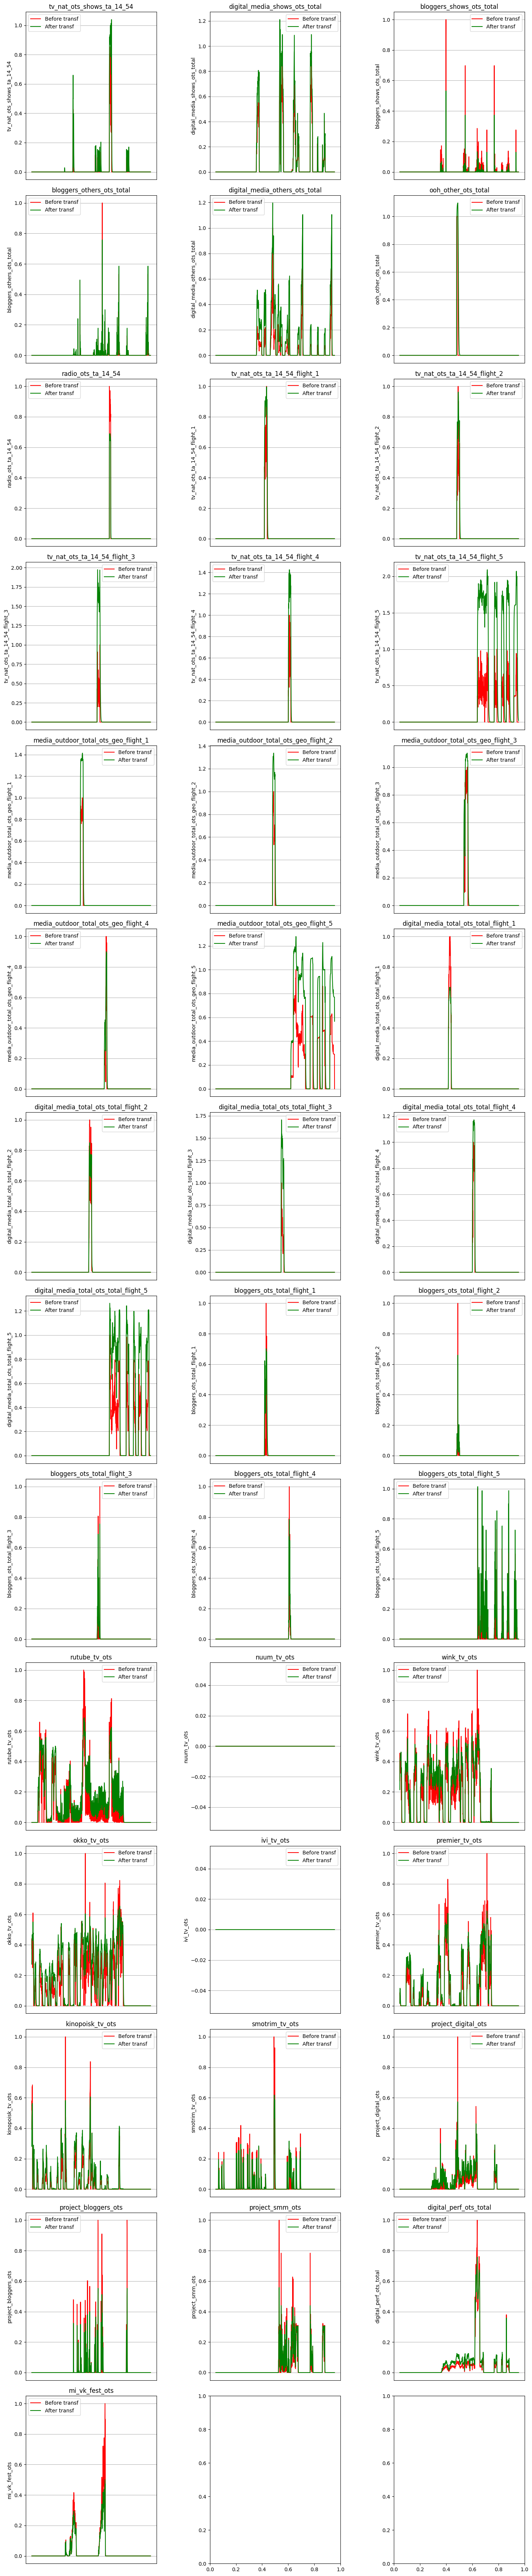

In [6]:
plot_transformed_data(df, df_transformed, list(media_params_optimal.keys()))

In [7]:
df_sc_fin = df.drop(df_transformed.columns, axis=1).join(df_transformed)

### Transformation aggregative media factors

In [8]:
media_params_input = pd.read_excel(file_path, sheet_name='agg_media_factors')
media_params_optimal = create_optimal_params_dict(
    media_params_input, 
    media_params_input['media'],
)

In [9]:
df_transformed_agg = transform_media_data(
    df,
    media_params_optimal,
    list(media_params_optimal.keys()),
    is_adstock=True,
    is_saturate=True,
    saturate_func='saturate_power',
)

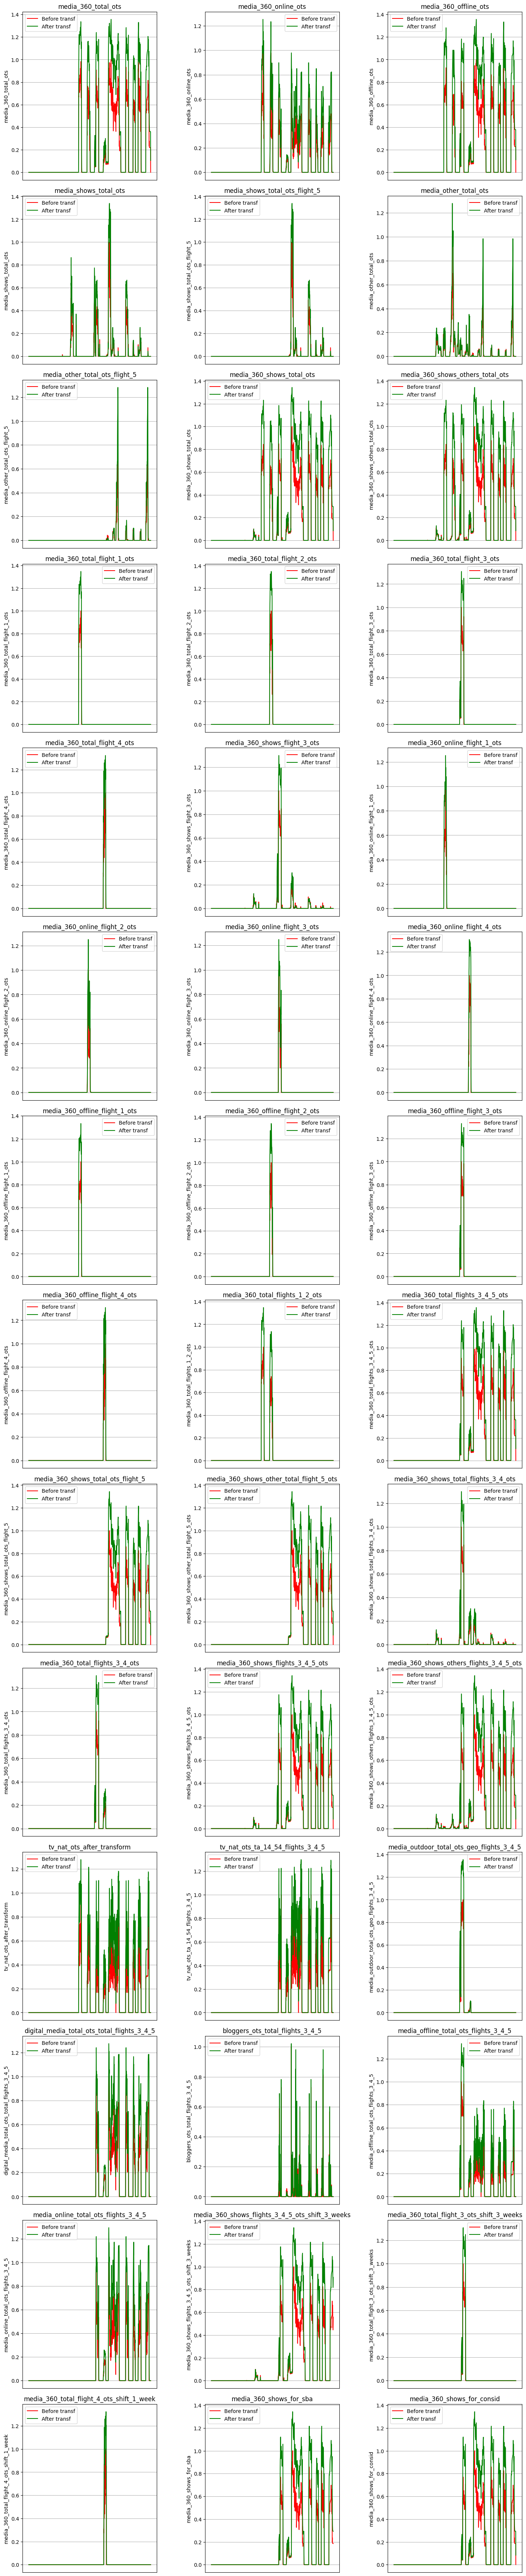

In [10]:
plot_transformed_data(df, df_transformed_agg, list(media_params_optimal.keys()))

## Final dataset

In [11]:
df_scaled_fin = df_sc_fin.drop(df_transformed_agg.columns, axis=1).join(df_transformed_agg)

## Feature engeneering

## Other factors

In [12]:
df_scaled_fin['const'] = 1.
df_scaled_fin['competitors_tv_total_ots'] = df_scaled_fin[['rutube_tv_ots', 'okko_tv_ots']].sum(axis=1)

df_scaled_fin['dummy_new_base_flight1'] = 0
df_scaled_fin.loc['2023-10-01':'2023-10-15','dummy_new_base_flight1'] = 0.5
df_scaled_fin.loc['2023-10-15':,'dummy_new_base_flight1'] = 1

df_scaled_fin['dummy_new_base_flight2'] = 0
df_scaled_fin.loc['2024-01-14':'2024-01-30','dummy_new_base_flight2'] = 0.5
df_scaled_fin.loc['2024-01-30':,'dummy_new_base_flight2'] = 1

df_scaled_fin['dummy_new_base_flight3'] = 0
df_scaled_fin.loc['2024-04-28':'2024-05-12','dummy_new_base_flight3'] = 0.5
df_scaled_fin.loc['2024-05-12':,'dummy_new_base_flight3'] = 1

df_scaled_fin['dummy_new_base_flight4'] = 0
df_scaled_fin.loc['2024-09-01':'2024-10-06','dummy_new_base_flight4'] = 0.5
df_scaled_fin.loc['2024-10-07':,'dummy_new_base_flight4'] = 1

## Seasonality

13:43:33 - cmdstanpy - INFO - Chain [1] start processing
13:43:33 - cmdstanpy - INFO - Chain [1] done processing


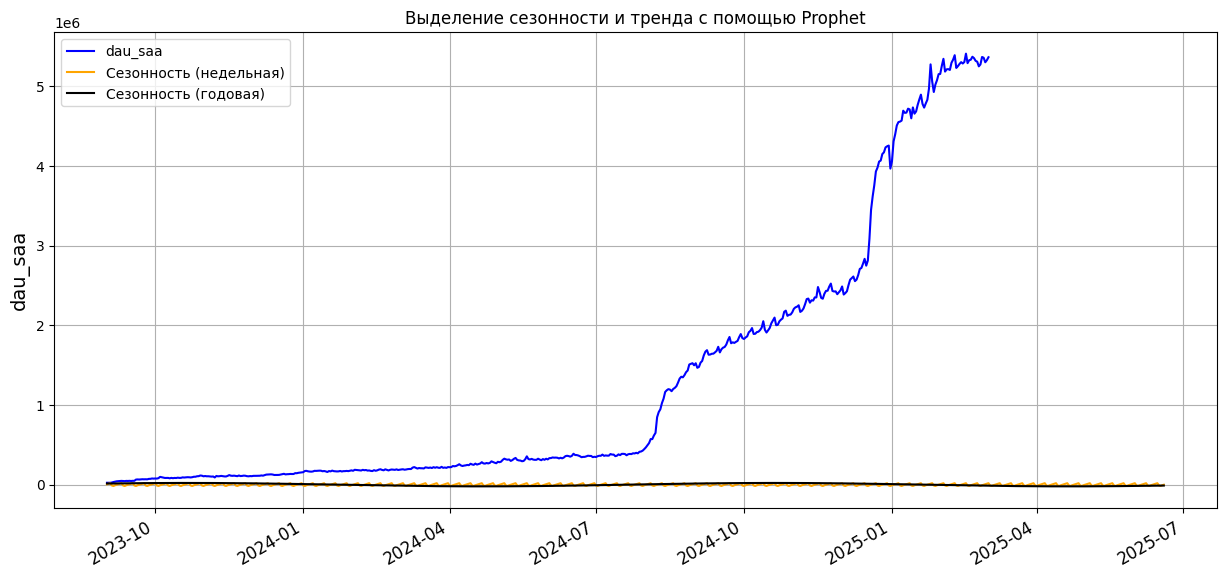

In [13]:
kpi = 'dau_saa'
date_start_dau_saa = '2023-09-01'
date_end_dau_saa = df_scaled_fin.loc[~df_scaled_fin.dau_saa.eq(0),kpi].index.max()
data = df_scaled_fin.loc[date_start_dau_saa:date_end_dau_saa].reset_index().rename(columns = {kpi: 'y', 'date': 'ds'})

holidays = pd.read_csv('../../data/data_factors/prophet_holidays_daily.csv', parse_dates = ['ds'], sep=';').dropna()
holidays['ds'] = pd.to_datetime(holidays['ds'], format='%d.%m.%Y').dt.strftime("%m.%d.%Y")

model = Prophet(growth='linear',
            seasonality_mode='additive',
            weekly_seasonality=True,            
            yearly_seasonality=1, # 1 гармоники 
            seasonality_prior_scale=30)
# model.add_country_holidays(country_name='RU')
# model.add_regressor(name='holiday')

model.fit(data)

future = model.make_future_dataframe(periods=109)

forecast = model.predict(future)

# Визуализация результатов
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(data['ds'], data['y'], label=kpi, color='blue')
# ax.plot(forecast['ds'], forecast['trend'], label='Тренд', color='green')
ax.plot(forecast['ds'], forecast['weekly'], label='Сезонность (недельная)', color='orange')
ax.plot(forecast['ds'], forecast['yearly'], label='Сезонность (годовая)', color='black')
# ax.plot(forecast['ds'], forecast['holidays'], label='праздники', color='red')
plt.legend()
plt.grid(True)
plt.title('Выделение сезонности и тренда с помощью Prophet')
plt.xticks(fontsize=12)
plt.ylabel(kpi,fontsize=14)
# ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.show()

forecast.rename(columns= {'ds':'date'},inplace=True)
forecast.set_index('date',inplace=True)

In [14]:
df_scaled_fin['seasonality_weekly'] = forecast['weekly']
df_scaled_fin['seasonality_yearly'] = forecast['yearly']

# Modelling

## Prediction Rutube Installs

In [15]:
kpi = 'rutube_loss_installs'
# Нужно доделать, добавив установки из рустора
max_non_zero_date = df_scaled_fin.loc[~df_scaled_fin.rutube_loss_installs.eq(0)].index.max()
# экспраполируем последующие значения одним числом
# После того, как будут получены установки из Рустора, будет совершена модификация
df_scaled_fin.loc[max_non_zero_date + timedelta(days=1):,kpi] = df_scaled_fin.loc[~df_scaled_fin.rutube_loss_installs.eq(0)].rutube_loss_installs[-1]

## Prediction organic installs via Prophet

13:43:34 - cmdstanpy - INFO - Chain [1] start processing
13:43:34 - cmdstanpy - INFO - Chain [1] done processing


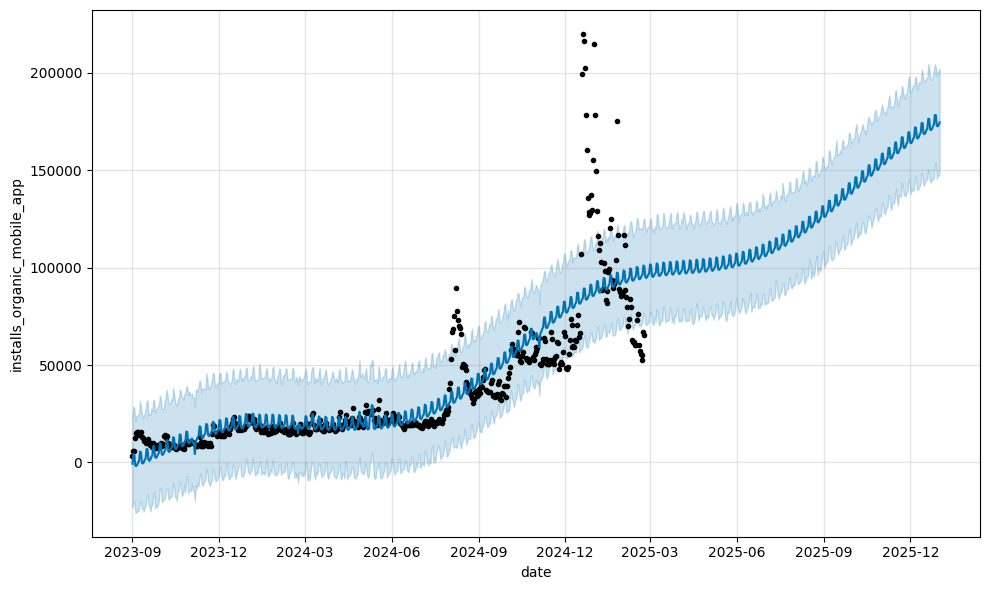

In [16]:
kpi='installs_organic_mobile_app'
date_start_org_installs = '2023-09-01'
date_last_dau_org_installs = df_scaled_fin[~df_scaled_fin[kpi].eq(0)].index.max() 
model = Prophet(growth='linear',
            seasonality_mode='additive', 
            weekly_seasonality=True,
            holidays=holidays,
            yearly_seasonality=1, # 2 гармоники 
            seasonality_prior_scale=30)

data = df_scaled_fin.loc[date_start_org_installs:date_last_dau_org_installs,].reset_index().rename(columns = {kpi: 'y', 'date': 'ds'})

model.fit(data)

date_diff = (pd.to_datetime('2026-01-01') - date_last_dau_org_installs).days

future = model.make_future_dataframe(periods=date_diff)

# future['cap'] = trend(horizont)

forecast = model.predict(future)

# Визуализация результатов
fig = model.plot(forecast,ylabel=kpi,xlabel='date')
forecast.index = forecast.ds


In [17]:
date_forecast =  df_scaled_fin[~df_scaled_fin[kpi].eq(0)].index.max() + timedelta(days=1)
df_scaled_fin['installs_organic_prophet_mean'] = pd.concat([df_scaled_fin.loc[date_start_org_installs:date_last_dau_org_installs,kpi],forecast['yhat'].loc[date_forecast:]])
df_scaled_fin['installs_organic_prophet_uci'] = pd.concat([df_scaled_fin.loc[date_start_org_installs:date_last_dau_org_installs,kpi],forecast['yhat_upper'].loc[date_forecast:]])
df_scaled_fin['installs_organic_prophet_lci'] = pd.concat([df_scaled_fin.loc[date_start_org_installs:date_last_dau_org_installs,kpi],forecast['yhat_lower'].loc[date_forecast:]])

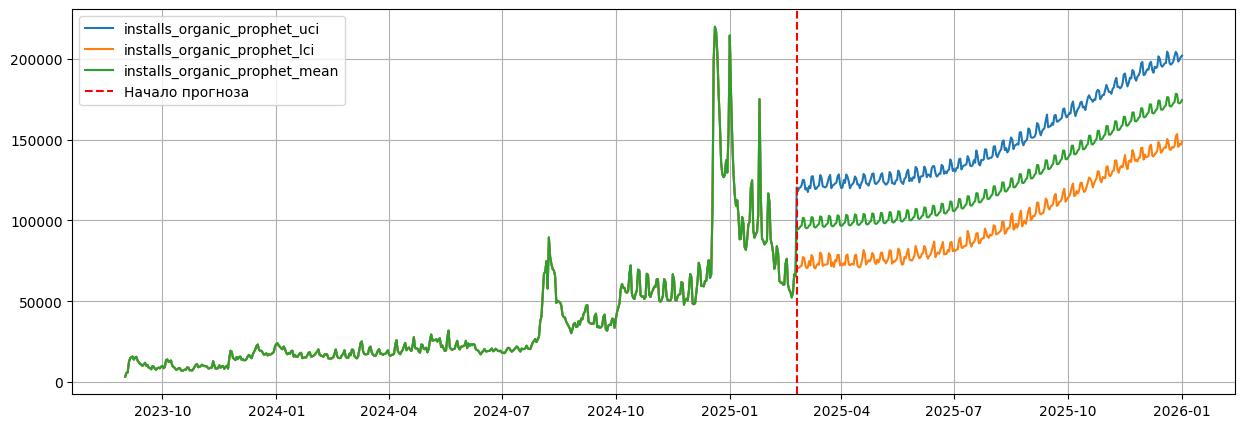

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(df_scaled_fin[['installs_organic_prophet_uci','installs_organic_prophet_lci','installs_organic_prophet_mean']])
plt.axvline(x=np.datetime64(date_forecast), color='red', linestyle='--', label='Начало прогноза')
plt.legend(['installs_organic_prophet_uci','installs_organic_prophet_lci','installs_organic_prophet_mean','Начало прогноза'])
plt.grid(True)
plt.show()

In [19]:
df_scaled_fin['rutube_installs_total_gp_ios'] = df_scaled_fin[['rutube_installs_android','rutube_installs_ios']].sum(axis=1)
df_scaled_fin['dummy_rutube_out_from_android'] = 0.
df_scaled_fin.loc['2024-01-10':,'dummy_rutube_out_from_android'] = 1.

df_scaled_fin['loss_rutube_from_android']= 0.
df_scaled_fin.loc['2024-10-01': , 'loss_rutube_from_android'] = abs((df_scaled_fin.rutube_installs_rustore + df_scaled_fin.rutube_installs_android).loc['2024-09-30'] - df_scaled_fin.rutube_installs_rustore.loc['2024-10-01':])


date_train_start = date_start_dau_saa
date_train_end = date_end_dau_saa

date_end_rise = pd.to_datetime('2024-10-10')
# Задаем начальное и конечное значение
start = 10000.
end = df_scaled_fin.rutube_installs_android.loc['2024-09-30']
num_points = (date_end_rise - pd.to_datetime('2024-09-30')).days

# Генерируем логарифмически распределенные точки
# log_space_points = np.logspace(np.log10(start), np.log10(end), num=num_points)
lin_space_points = np.linspace(start, end, num=num_points)

df_scaled_fin['lin_rise_loss_rutube_from_android']= 0.
df_scaled_fin.loc['2024-10-01':date_end_rise, 'lin_rise_loss_rutube_from_android'] = np.sort(lin_space_points)

df_scaled_fin.loc[date_end_rise+timedelta(days=1):date_train_end, 'lin_rise_loss_rutube_from_android'] += (df_scaled_fin.rutube_installs_rustore.loc['2024-10-01':date_train_end] + end)

In [20]:
df_scaled_fin.lin_rise_loss_rutube_from_android.iplot()

In [21]:
df_scaled_fin['paid_install_since_august'] = np.where(df_scaled_fin.index < '2024-08-01', 0, df_scaled_fin.installs_paid_mobile_app)
df_scaled_fin['log_rise_installs'] = 0.
date_diff = (pd.to_datetime('2024-08-15') - pd.to_datetime('2024-07-22')).days
log_space=np.logspace(start=0.5,stop=1.4, num=date_diff)
df_scaled_fin['log_rise_org_installs'] = 0.
df_scaled_fin.loc['2024-07-23':'2024-08-15', 'log_rise_org_installs'] =  np.sort(log_space)
df_scaled_fin.loc[date_end_dau_saa+timedelta(days=1):'2024-08-31','log_rise_org_installs'] = log_space.max()
df_scaled_fin['dummy_gap_org_installs'] = 0.
df_scaled_fin.loc['2024-08-02':'2024-08-13','dummy_gap_org_installs'] = 1.
#-------------------------------
factors = [ 
            # 'const',
            # 'media_shows_total_ots',
            # 'media_360_shows_total_flights_3_4_ots',
            # 'media_360_total_flight_5_ots',
            # 'log_rise_installs',
            # 'ba_spontaneous_roll_kpi_percent_14_54',
            'dummy_gap_org_installs',
            'media_360_shows_other_total_flight_5_ots',
            # 'media_360_shows_total_flights_3_4_ots',
            # 'media_360_shows_flights_3_4_5_ots',
            # 'rutube_loss_installs',
            # 'loss_rutube_from_android',
            'lin_rise_loss_rutube_from_android',
            # 'rutube_installs_android',
            # 'dummy_rutube_out_from_android',
            # 'rutube_installs_ios',
            # 'rutube_installs_rustore',
            # 'rutube_installs_total_gp_ios',
            # 'rutube_total_installs',
            # 'ba_spontaneous_roll_kpi_percent_14_54',
            # 'project_smm_ots',
            # 'project_pr_ots',
            # 'media_360_total_flight_5_ots',
            'mqp_bloggers_tvt_30s_hours',
            'digital_perf_spends',
            # 'project_aso_google_play',
            # 'paid_install_since_august',
            # 'const',
            # 'project_digital_ots',
            'project_aso_app_store'
            ]

kpi = 'installs_organic_mobile_app'

In [22]:
y = df_scaled_fin.loc[date_train_start:date_train_end,kpi].loc[:'2024-10-25']
X = df_scaled_fin.loc[date_train_start:date_train_end,factors].loc[:'2024-10-25']

model_organic_installs = sm.OLS(y, X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(model_organic_installs.summary())

installs_organic_media_pred = model_organic_installs.fittedvalues
y_pred = model_organic_installs.fittedvalues
print('SMAPE on train: ', round(SMAPE(y, y_pred), 2), '%')

# model_organic_installs = pd.read_pickle('../../models/organic_installs.pkl')
# installs_organic_media_pred = model_organic_installs.fittedvalues

                                     OLS Regression Results                                     
Dep. Variable:     installs_organic_mobile_app   R-squared (uncentered):                   0.975
Model:                                     OLS   Adj. R-squared (uncentered):              0.975
Method:                          Least Squares   F-statistic:                              1203.
Date:                         Fri, 07 Mar 2025   Prob (F-statistic):                   2.13e-244
Time:                                 13:43:34   Log-Likelihood:                         -4119.4
No. Observations:                          421   AIC:                                      8251.
Df Residuals:                              415   BIC:                                      8275.
Df Model:                                    6                                                  
Covariance Type:                           HAC                                                  
                              

In [23]:
plot_decomposition(pd.concat([X,y],axis=1),model_organic_installs,kpi_name=kpi)

In [24]:
date_flight_start= '2024-09-02'
date_flight_end = '2024-10-06'

tv_share = df_scaled_fin['tv_nat_ots_ta_14_54_flight_5'] / df_scaled_fin[['tv_nat_ots_ta_14_54_flight_5','media_outdoor_total_ots_geo_flight_5', 'digital_media_total_ots_total_flight_5',
                                    'bloggers_ots_total_flight_5', 'tv_nat_ots_shows_ta_14_54', 'digital_media_shows_ots_total', 'bloggers_shows_ots_total','radio_ots_ta_14_54']].loc[date_flight_start:date_flight_end].sum(axis=1)
df_scaled_fin['tv_360_impact'] = tv_share*df_scaled_fin.media_360_shows_other_total_flight_5_ots

ooh_share = df_scaled_fin['media_outdoor_total_ots_geo_flight_5'] / df_scaled_fin[['tv_nat_ots_ta_14_54_flight_5','media_outdoor_total_ots_geo_flight_5', 'digital_media_total_ots_total_flight_5',
                                    'bloggers_ots_total_flight_5', 'tv_nat_ots_shows_ta_14_54', 'digital_media_shows_ots_total', 'bloggers_shows_ots_total','radio_ots_ta_14_54']].loc[date_flight_start:date_flight_end].sum(axis=1)
df_scaled_fin['ooh_360_impact'] = ooh_share*df_scaled_fin.media_360_shows_other_total_flight_5_ots


digital_media_share = df_scaled_fin['digital_media_total_ots_total_flight_5'] / df_scaled_fin[['tv_nat_ots_ta_14_54_flight_5','media_outdoor_total_ots_geo_flight_5', 'digital_media_total_ots_total_flight_5',
                                    'bloggers_ots_total_flight_5', 'tv_nat_ots_shows_ta_14_54', 'digital_media_shows_ots_total', 'bloggers_shows_ots_total','radio_ots_ta_14_54']].loc[date_flight_start:date_flight_end].sum(axis=1) 
df_scaled_fin['digital_media_360_impact'] = digital_media_share*df_scaled_fin.media_360_shows_other_total_flight_5_ots

bloggers_share = df_scaled_fin['bloggers_ots_total_flight_5'] / df_scaled_fin[['tv_nat_ots_ta_14_54_flight_5','media_outdoor_total_ots_geo_flight_5', 'digital_media_total_ots_total_flight_5',
                                    'bloggers_ots_total_flight_5', 'tv_nat_ots_shows_ta_14_54', 'digital_media_shows_ots_total', 'bloggers_shows_ots_total','radio_ots_ta_14_54']].loc[date_flight_start:date_flight_end].sum(axis=1) 
df_scaled_fin['bloggers_360_impact'] = bloggers_share*df_scaled_fin.media_360_shows_other_total_flight_5_ots


tv_shows_share = df_scaled_fin['tv_nat_ots_shows_ta_14_54'] / df_scaled_fin[['tv_nat_ots_ta_14_54_flight_5','media_outdoor_total_ots_geo_flight_5', 'digital_media_total_ots_total_flight_5',
                                    'bloggers_ots_total_flight_5', 'tv_nat_ots_shows_ta_14_54', 'digital_media_shows_ots_total', 'bloggers_shows_ots_total','radio_ots_ta_14_54']].loc[date_flight_start:date_flight_end].sum(axis=1) 
df_scaled_fin['tv_shows_impact'] = tv_shows_share*df_scaled_fin.media_360_shows_other_total_flight_5_ots


digital_media_shows_share = df_scaled_fin['digital_media_shows_ots_total'] / df_scaled_fin[['tv_nat_ots_ta_14_54_flight_5','media_outdoor_total_ots_geo_flight_5', 'digital_media_total_ots_total_flight_5',
                                    'bloggers_ots_total_flight_5', 'tv_nat_ots_shows_ta_14_54', 'digital_media_shows_ots_total', 'bloggers_shows_ots_total','radio_ots_ta_14_54']].loc[date_flight_start:date_flight_end].sum(axis=1)
df_scaled_fin['digital_media_shows_impact'] = digital_media_shows_share*df_scaled_fin.media_360_shows_other_total_flight_5_ots


bloggers_shows_share = df_scaled_fin['bloggers_shows_ots_total'] / df_scaled_fin[['tv_nat_ots_ta_14_54_flight_5','media_outdoor_total_ots_geo_flight_5', 'digital_media_total_ots_total_flight_5',
                                    'bloggers_ots_total_flight_5', 'tv_nat_ots_shows_ta_14_54', 'digital_media_shows_ots_total', 'bloggers_shows_ots_total','radio_ots_ta_14_54']].loc[date_flight_start:date_flight_end].sum(axis=1)
df_scaled_fin['bloggers_shows_impact'] = bloggers_shows_share*df_scaled_fin.media_360_shows_other_total_flight_5_ots

radio_share = df_scaled_fin['radio_ots_ta_14_54'] / df_scaled_fin[['tv_nat_ots_ta_14_54_flight_5','media_outdoor_total_ots_geo_flight_5', 'digital_media_total_ots_total_flight_5',
                                    'bloggers_ots_total_flight_5', 'tv_nat_ots_shows_ta_14_54', 'digital_media_shows_ots_total', 'bloggers_shows_ots_total','radio_ots_ta_14_54']].loc[date_flight_start:date_flight_end].sum(axis=1)
df_scaled_fin['radio_impact'] = radio_share*df_scaled_fin.media_360_shows_other_total_flight_5_ots




In [25]:
df_flowchart = pd.DataFrame({'date_start':[pd.to_datetime(date_flight_start)], 
                                             'date_end':[pd.to_datetime(date_flight_end)], 
                                             'budget':[0.]},
                             index=['tv_360_impact', 
                                    'ooh_360_impact',
                                    'digital_media_360_impact',
                                    'bloggers_360_impact',
                                    'radio_impact', 
                                    'tv_shows_impact',
                                    'digital_media_shows_impact',
                                    'bloggers_shows_impact',
                                    #------------------
                                    'media_360_shows_other_total_flight_5_ots',
                                    'lin_rise_loss_rutube_from_android',
                                    'digital_perf_spends',
                                    'mqp_bloggers_tvt_30s_hours',
                                    'dummy_gap_org_installs',
                                   #  'project_smm_ots',
                                    'project_aso_app_store'])

In [26]:
upd_params = pd.Series({
                        'tv_360_impact':model_organic_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        'ooh_360_impact':model_organic_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        'digital_media_360_impact':model_organic_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        'bloggers_360_impact':model_organic_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        #-------------------------------------------------------------------------------
                        'tv_shows_impact':model_organic_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        'digital_media_shows_impact':model_organic_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        'bloggers_shows_impact':model_organic_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        'radio_impact':model_organic_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        #-------------------------------------------------------------------------------
                        'media_360_shows_other_total_flight_5_ots':model_organic_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        #-------------------------------------------------------------------------------
                        'lin_rise_loss_rutube_from_android':model_organic_installs.params.get('lin_rise_loss_rutube_from_android'),
                        'digital_perf_spends':model_organic_installs.params.get('digital_perf_spends'),
                        'mqp_bloggers_tvt_30s_hours':model_organic_installs.params.get('mqp_bloggers_tvt_30s_hours'),
                     #    'project_smm_ots':model_organic_installs.params.get('project_smm_ots'),
                        'dummy_gap_org_installs':model_organic_installs.params.get('dummy_gap_org_installs'),
                        'project_aso_app_store':model_organic_installs.params.get('project_aso_app_store'),
                       })

In [27]:
media_impact_mean_nested = calculate_media_impact(df_scaled_fin,
             df_flow_init=df_flowchart,
             media_factors=['tv_360_impact', 
                            'ooh_360_impact',
                            'digital_media_360_impact',
                            'bloggers_360_impact',
                            'radio_impact', 
                            'tv_shows_impact',
                            'digital_media_shows_impact',
                            'bloggers_shows_impact'],
             other_factors=['media_360_shows_other_total_flight_5_ots',
                            'lin_rise_loss_rutube_from_android',
                            'digital_perf_spends',
                            'mqp_bloggers_tvt_30s_hours',
                            'dummy_gap_org_installs',
                            # 'project_smm_ots',
                            'project_aso_app_store'],
             target=kpi,
             model=model_organic_installs,
             model_params=upd_params, 
             avg_over_period=False) # сумма
media_impact_mean_nested

Scenario without advertising campaign: 1141065.19858


date_start   date_end  budget  \
tv_360_impact                            2024-09-02 2024-10-06   0.000   
ooh_360_impact                           2024-09-02 2024-10-06   0.000   
digital_media_360_impact                 2024-09-02 2024-10-06   0.000   
bloggers_360_impact                      2024-09-02 2024-10-06   0.000   
radio_impact                             2024-09-02 2024-10-06   0.000   
tv_shows_impact                          2024-09-02 2024-10-06   0.000   
digital_media_shows_impact               2024-09-02 2024-10-06   0.000   
bloggers_shows_impact                    2024-09-02 2024-10-06   0.000   
media_360_shows_other_total_flight_5_ots 2024-09-02 2024-10-06   0.000   
lin_rise_loss_rutube_from_android        2024-09-02 2024-10-06   0.000   
digital_perf_spends                      2024-09-02 2024-10-06   0.000   
mqp_bloggers_tvt_30s_hours               2024-09-02 2024-10-06   0.000   
dummy_gap_org_installs                   2024-09-02 2024-10-06   0.000   
project_aso_app_store                    2024-09-02 2024-10-06   0.000   
media_total                              2024-09-02 2024-10-06   0.000   

                                          target_fact  impact_weighted  \
tv_360_impact                             1391247.000        76876.413   
ooh_360_impact                            1391247.000        54213.413   
digital_media_360_impact                  1391247.000        41795.102   
bloggers_360_impact                       1391247.000         8430.732   
radio_impact                              1391247.000        13816.184   
tv_shows_impact                           1391247.000        32446.960   
digital_media_shows_impact                1391247.000        22148.079   
bloggers_shows_impact                     1391247.000          454.919   
media_360_shows_other_total_flight_5_ots  1391247.000       250181.801   
lin_rise_loss_rutube_from_android         1391247.000        36081.560   
digital_perf_spends                       1391247.000      -121957.699   
mqp_bloggers_tvt_30s_hours                1391247.000      1012837.872   
dummy_gap_org_installs                    1391247.000            0.000   
project_aso_app_store                     1391247.000       214103.465   
media_total                               1391247.000       250181.801   

                                          increment  share    CPA  coefficient  
tv_360_impact                                 5.849  5.526  0.000     5940.672  
ooh_360_impact                                4.055  3.897  0.000     5940.672  
digital_media_360_impact                      3.097  3.004  0.000     5940.672  
bloggers_360_impact                           0.610  0.606  0.000     5940.672  
radio_impact                                  1.003  0.993  0.000     5940.672  
tv_shows_impact                               2.388  2.332  0.000     5940.672  
digital_media_shows_impact                    1.618  1.592  0.000     5940.672  
bloggers_shows_impact                         0.033  0.033  0.000     5940.672  
media_360_shows_other_total_flight_5_ots     21.925 17.983  0.000     5940.672  
lin_rise_loss_rutube_from_android             2.663  2.593  0.000        0.236  
digital_perf_spends                          -8.060 -8.766 -0.000       -0.000  
mqp_bloggers_tvt_30s_hours                  267.657 72.801  0.000    69851.818  
dummy_gap_org_installs                        0.000  0.000    NaN    36658.682  
project_aso_app_store                        18.188 15.389  0.000    27085.036  
media_total                                  21.925 17.983  0.000          NaN

In [28]:
filepath = '../../results/sept_pba/results_nested_organic_installs1.xlsx'
media_impact_mean_nested.to_excel(filepath, sheet_name='main')

### Convertation media impact for organic installs to DAU

In [29]:
date_flight_start = pd.to_datetime('2024-09-02')
date_flight_end = pd.to_datetime('2024-10-06')
# date_flight_start = date_flight_end - timedelta(days=157)
pd.set_option('display.float_format', '{:.3f}'.format)
res = pd.DataFrame()
y_predict_flight = y_pred.loc[date_flight_start:date_flight_end]
tv_impact = upd_params.get('tv_360_impact')* df_scaled_fin['tv_360_impact'].loc[date_flight_start:date_flight_end]
share_tv_impact = tv_impact/y_predict_flight

tv_shows_impact = upd_params.get('tv_shows_impact')* df_scaled_fin['tv_shows_impact'].loc[date_flight_start:date_flight_end]
share_tv_shows_impact = tv_shows_impact/y_predict_flight


ooh_impact = upd_params.get('ooh_360_impact')* df_scaled_fin['ooh_360_impact'].loc[date_flight_start:date_flight_end]
share_ooh_impact = ooh_impact/y_predict_flight



digital_media_impact= upd_params.get('digital_media_360_impact')* df_scaled_fin['digital_media_360_impact'].loc[date_flight_start:date_flight_end]
share_digital_media_impact = digital_media_impact / y_predict_flight

digital_media_shows_impact = upd_params.get('digital_media_shows_impact')* df_scaled_fin['digital_media_shows_impact'].loc[date_flight_start:date_flight_end]
share_digital_media_shows_impact = digital_media_shows_impact / y_predict_flight


bloggers_impact = upd_params.get('bloggers_360_impact')* df_scaled_fin['bloggers_360_impact'].loc[date_flight_start:date_flight_end]
share_bloggers_impact = bloggers_impact / y_predict_flight


bloggers_shows_impact = upd_params.get('bloggers_shows_impact')* df_scaled_fin['bloggers_shows_impact'].loc[date_flight_start:date_flight_end]
share_bloggers_shows_impact = bloggers_shows_impact / y_predict_flight

radio_impact = upd_params.get('radio_impact')* df_scaled_fin['radio_impact'].loc[date_flight_start:date_flight_end]
share_radio_impact = radio_impact / y_predict_flight


loss_rutube = upd_params.get('lin_rise_loss_rutube_from_android')* df_scaled_fin['lin_rise_loss_rutube_from_android'].loc[date_flight_start:date_flight_end]
share_loss_rutube = loss_rutube/y_predict_flight


digital_perf_spends = upd_params.get('digital_perf_spends')* df_scaled_fin['digital_perf_spends'].loc[date_flight_start:date_flight_end]
share_digital_perf_spends = digital_perf_spends/y_predict_flight


mqp_bloggers = upd_params.get('mqp_bloggers_tvt_30s_hours')* df_scaled_fin['mqp_bloggers_tvt_30s_hours'].loc[date_flight_start:date_flight_end]
share_mqp_bloggers = mqp_bloggers/y_predict_flight


dummy_gap_org_installs = upd_params.get('dummy_gap_org_installs')* df_scaled_fin['dummy_gap_org_installs'].loc[date_flight_start:date_flight_end]
share_dummy_gap_org_installs = dummy_gap_org_installs/y_predict_flight

project_aso_app_store = upd_params.get('project_aso_app_store')* df_scaled_fin['project_aso_app_store'].loc[date_flight_start:date_flight_end]
share_project_aso_app_store = project_aso_app_store/y_predict_flight

res['tv_impact'] = share_tv_impact*y.loc[date_flight_start:date_flight_end]
res['tv_shows_impact'] = share_tv_shows_impact*y.loc[date_flight_start:date_flight_end]

res['ooh_impact'] = share_ooh_impact*y.loc[date_flight_start:date_flight_end]

res['digital_media_impact'] = share_digital_media_impact*y.loc[date_flight_start:date_flight_end]
res['digital_media_shows_impact'] = share_digital_media_shows_impact*y.loc[date_flight_start:date_flight_end]

res['bloggers_impact'] = share_bloggers_impact*y.loc[date_flight_start:date_flight_end]
res['bloggers_shows_impact'] = share_bloggers_shows_impact*y.loc[date_flight_start:date_flight_end]

res['radio_impact'] = share_radio_impact*y.loc[date_flight_start:date_flight_end]

factors_media = ['tv_impact','tv_shows_impact','ooh_impact', 
                 'digital_media_impact','digital_media_shows_impact', 'bloggers_impact','bloggers_shows_impact','radio_impact']

res['media_total_impact'] = res[factors_media].sum(axis=1)
res['media_total_impact_%'] = res['media_total_impact']/y_predict_flight

res['loss_rutube'] = share_loss_rutube*y.loc[date_flight_start:date_flight_end]
res['digital_perf_spends'] = share_digital_perf_spends*y.loc[date_flight_start:date_flight_end]
res['mqp_bloggers'] = share_mqp_bloggers*y.loc[date_flight_start:date_flight_end]
res['dummy_gap_org_installs'] = share_dummy_gap_org_installs*y.loc[date_flight_start:date_flight_end]
res['project_aso_app_store'] = share_project_aso_app_store*y.loc[date_flight_start:date_flight_end]

res['y_predict'] = y_predict_flight
res['y_fact'] = y
# группировка по неделям 
res_weeks = res.resample(rule='W-MON', label='left').sum()
res_weeks['media_total_impact_%'] = res_weeks['media_total_impact']/res_weeks.y_predict*100

# группировка по месяцам 
res_months = res.resample(rule='M', label='left').sum()
res_months['media_total_impact_%'] = res_months['media_total_impact']/res_months.y_predict*100
res_months.index = res_months.index + timedelta(days=1)

In [30]:
with pd.ExcelWriter(filepath, engine='openpyxl', mode='a') as writer:
    # Сохраняем датафрейм на отдельный лист в существующем файле
    res.to_excel(writer, sheet_name='decompose_days')
    res_weeks.to_excel(writer, sheet_name='decompose_weeks')
    res_months.to_excel(writer, sheet_name='decompose_months')

In [31]:
organic_retention = pd.read_excel('../../data/retentions/vkvideo_retention_data_30+.xlsx',sheet_name='organic_retention')
organic_retention.set_index('date',inplace=True)
organic_retention.insert(0, '0', 1.)
mean_organic_retention = organic_retention.mean(axis=0)[:36]
date_forecast = pd.date_range(date_flight_start,date_flight_end)
dau_organic_forecast = {}
for j in factors_media:
    dau_organic_forecast[j] = []
    for i in date_forecast:
        start_date = i - timedelta(days=35)
        mean_organic_retention_reverse = mean_organic_retention[::-1]
        mean_organic_retention_reverse.index = pd.date_range(start_date,i)
        dau_i = (res[j].loc[start_date:i] * mean_organic_retention_reverse).sum()
        dau_organic_forecast[j].append(dau_i)
dau_organic_forecast = pd.DataFrame(dau_organic_forecast, index = date_forecast)

In [32]:
dau_organic_forecast.mean()

tv_impact                    5124.273
tv_shows_impact              2423.707
ooh_impact                   3663.412
digital_media_impact         2972.390
digital_media_shows_impact   1688.429
bloggers_impact               622.876
bloggers_shows_impact          35.086
radio_impact                 1209.088
dtype: float64

## Prediction growth installs via Prophet

13:43:35 - cmdstanpy - INFO - Chain [1] start processing
13:43:35 - cmdstanpy - INFO - Chain [1] done processing


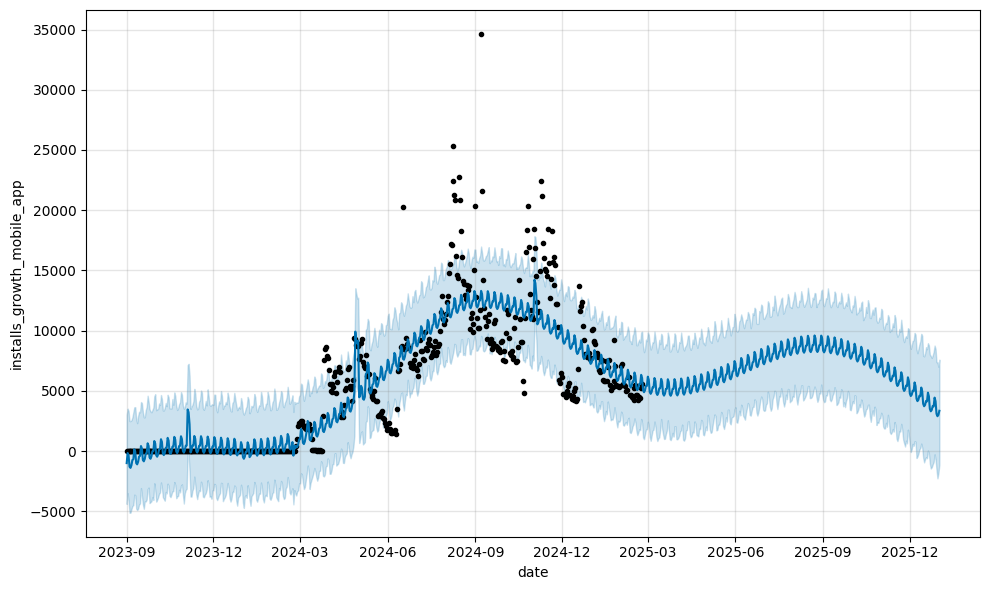

In [33]:
kpi='installs_growth_mobile_app'
date_start_growth_installs = date_start_dau_saa #'2024-02-27'
date_last_dau_growth_installs = df_scaled_fin[~df_scaled_fin[kpi].eq(0)].index.max() 
model = Prophet(growth='linear',
            seasonality_mode='additive', 
            weekly_seasonality=True,
            holidays=holidays,
            yearly_seasonality=1, # 2 гармоники 
            seasonality_prior_scale=30)

data = df_scaled_fin.loc[date_start_growth_installs:date_last_dau_growth_installs].reset_index().rename(columns = {kpi: 'y', 'date': 'ds'})

model.fit(data)

date_diff = (pd.to_datetime('2026-01-01') - date_last_dau_growth_installs).days

future = model.make_future_dataframe(periods=date_diff)

# future['cap'] = trend(horizont)

forecast = model.predict(future)

# Визуализация результатов
fig = model.plot(forecast,ylabel=kpi,xlabel='date')
forecast.index = forecast.ds

In [34]:
date_forecast =  df_scaled_fin[~df_scaled_fin[kpi].eq(0)].index.max() + timedelta(days=1)
df_scaled_fin['installs_growth_prophet_mean'] = pd.concat([df_scaled_fin.loc[date_start_growth_installs:date_last_dau_growth_installs,kpi],forecast['yhat'].loc[date_forecast:]])
df_scaled_fin['installs_growth_prophet_uci'] = pd.concat([df_scaled_fin.loc[date_start_growth_installs:date_last_dau_growth_installs,kpi],forecast['yhat_upper'].loc[date_forecast:]])
df_scaled_fin['installs_growth_prophet_lci'] = pd.concat([df_scaled_fin.loc[date_start_growth_installs:date_last_dau_growth_installs,kpi],forecast['yhat_lower'].loc[date_forecast:]])

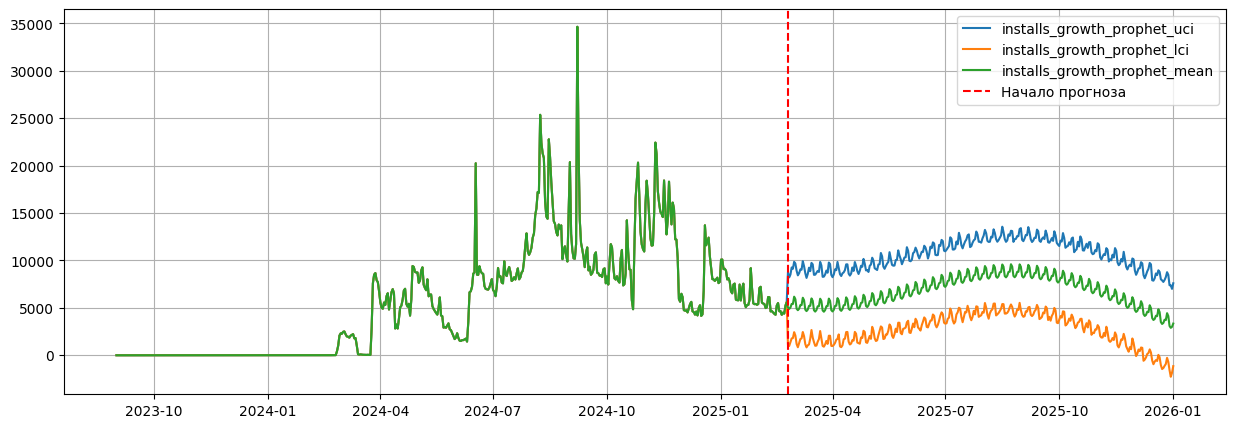

In [35]:
plt.figure(figsize=(15, 5))
plt.plot(df_scaled_fin[['installs_growth_prophet_uci','installs_growth_prophet_lci','installs_growth_prophet_mean']])
plt.axvline(x=np.datetime64(date_forecast), color='red', linestyle='--', label='Начало прогноза')
plt.legend(['installs_growth_prophet_uci','installs_growth_prophet_lci','installs_growth_prophet_mean','Начало прогноза'])
plt.grid(True)
plt.show()

In [36]:
factors = [
            'const',
            # 'media_shows_total_ots',
            # 'media_360_shows_total_flights_3_4_ots',
            # 'media_360_total_flight_5_ots',
            # 'log_rise_installs',
            # 'dummy_gap_org_installs',
            # 'media_360_shows_total_ots_flight_5',
            'media_360_shows_other_total_flight_5_ots',
            # 'digital_perf_ots_total',
            # 'mqp_bloggers_tvt_30s_hours',
            'project_pr_ots',
            'log_rise_growth_installs',
            'dummy_gap_growth_installs',
            # 'dummy_shift_installs_growth'
            ]

kpi = 'installs_growth_mobile_app'
df_scaled_fin['dummy_shift_installs_growth'] = 0.
df_scaled_fin.loc['2024-06-12':, 'dummy_shift_installs_growth'] = 1.0

df_scaled_fin['dummy_gap_growth_installs'] = 0.
df_scaled_fin.loc['2024-06-17', 'dummy_gap_growth_installs'] = 1.0
df_scaled_fin.loc['2024-08-15':'2024-08-21', 'dummy_gap_growth_installs'] = 1.0
df_scaled_fin.loc['2024-09-01', 'dummy_gap_growth_installs'] = 1.0
df_scaled_fin.loc['2024-09-07', 'dummy_gap_growth_installs'] = 1.0


date_diff = (pd.to_datetime('2024-08-11') - pd.to_datetime('2024-07-20')).days
log_space=np.logspace(start=0.5,stop=1.4, num=date_diff)
df_scaled_fin['log_rise_growth_installs'] = 0.
df_scaled_fin.loc['2024-07-21':'2024-08-11', 'log_rise_growth_installs'] =  np.sort(log_space)
# df_scaled_fin.loc[date_end_dau_saa+timedelta(days=1):'2024-08-15','log_rise_growth_installs'] = log_space.max()


In [37]:
date_train_start = '2024-03-27'#df_scaled_fin[~df_scaled_fin.installs_growth_mobile_app.eq(0)].installs_growth_mobile_app.index.min()
date_train_end = date_end_dau_saa
y = df_scaled_fin.loc[date_train_start:date_train_end,kpi]
X = df_scaled_fin.loc[date_train_start:date_train_end,factors]

model_growth_installs = sm.OLS(y, X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(model_growth_installs.summary())

installs_growth_media_pred = model_growth_installs.fittedvalues
y_pred = model_growth_installs.fittedvalues
print('SMAPE on train: ', round(SMAPE(y, y_pred), 2), '%')

# model_growth_installs = pd.read_pickle('../../models/growth_installs.pkl')
# installs_organic_media_pred = model_organic_installs.fittedvalues

                                OLS Regression Results                                
Dep. Variable:     installs_growth_mobile_app   R-squared:                       0.478
Model:                                    OLS   Adj. R-squared:                  0.472
Method:                         Least Squares   F-statistic:                     60.61
Date:                        Fri, 07 Mar 2025   Prob (F-statistic):           1.66e-38
Time:                                13:43:35   Log-Likelihood:                -3262.2
No. Observations:                         341   AIC:                             6534.
Df Residuals:                             336   BIC:                             6554.
Df Model:                                   4                                         
Covariance Type:                          HAC                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
---------------------

In [38]:
plot_decomposition(pd.concat([X,y],axis=1),model_growth_installs,kpi_name=kpi)

In [39]:
date_flight_start= '2024-09-02'
date_flight_end = '2024-10-06'
df_flowchart = pd.DataFrame({'date_start':[pd.to_datetime(date_flight_start)], 
                                             'date_end':[pd.to_datetime(date_flight_end)], 
                                             'budget':[0.]},
                             index=['tv_360_impact', 
                                    'ooh_360_impact',
                                    'digital_media_360_impact',
                                    'bloggers_360_impact',
                                    'radio_impact', 
                                    #-----------------------------
                                    'tv_shows_impact',
                                    'digital_media_shows_impact',
                                    'bloggers_shows_impact',
                                    #-----------------------------
                                    'media_360_shows_other_total_flight_5_ots',
                                   #  'mqp_bloggers_tvt_30s_hours',
                                    'project_pr_ots',
                                    'log_rise_growth_installs',
                                    'dummy_gap_growth_installs',
                                    'const'])
upd_params = pd.Series({
                        'tv_360_impact':model_growth_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        'ooh_360_impact':model_growth_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        'digital_media_360_impact':model_growth_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        'bloggers_360_impact':model_growth_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        'radio_impact':model_growth_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        #-------------------------------------------------------------------------------
                        'tv_shows_impact':model_growth_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        'digital_media_shows_impact':model_growth_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        'bloggers_shows_impact':model_growth_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        #-------------------------------------------------------------------------------
                        'media_360_shows_other_total_flight_5_ots':model_growth_installs.params.get('media_360_shows_other_total_flight_5_ots'),
                        #-------------------------------------------------------------------------------
                     #    'mqp_bloggers_tvt_30s_hours':model_growth_installs.params.get('mqp_bloggers_tvt_30s_hours'),
                        'project_pr_ots':model_growth_installs.params.get('project_pr_ots'),
                        'log_rise_growth_installs':model_growth_installs.params.get('log_rise_growth_installs'),
                        'dummy_gap_growth_installs':model_growth_installs.params.get('dummy_gap_growth_installs'),
                        'const':model_growth_installs.params.get('const'),
                       })

media_impact_mean_nested = calculate_media_impact(df_scaled_fin,
             df_flow_init=df_flowchart,
             media_factors=['tv_360_impact', 
                                    'ooh_360_impact',
                                    'digital_media_360_impact',
                                    'bloggers_360_impact',
                                    'radio_impact', 
                                    'tv_shows_impact',
                                    'digital_media_shows_impact',
                                    'bloggers_shows_impact',],
             other_factors=['media_360_shows_other_total_flight_5_ots', 
                            # 'mqp_bloggers_tvt_30s_hours',
                            'project_pr_ots',
                            'log_rise_growth_installs',
                            'dummy_gap_growth_installs',
                            'const'],
             target=kpi,
             model=model_organic_installs,
             model_params=upd_params,
             avg_over_period=False) # сумма
media_impact_mean_nested

Scenario without advertising campaign: 335033.41023


date_start   date_end  budget  \
tv_360_impact                            2024-09-02 2024-10-06   0.000   
ooh_360_impact                           2024-09-02 2024-10-06   0.000   
digital_media_360_impact                 2024-09-02 2024-10-06   0.000   
bloggers_360_impact                      2024-09-02 2024-10-06   0.000   
radio_impact                             2024-09-02 2024-10-06   0.000   
tv_shows_impact                          2024-09-02 2024-10-06   0.000   
digital_media_shows_impact               2024-09-02 2024-10-06   0.000   
bloggers_shows_impact                    2024-09-02 2024-10-06   0.000   
media_360_shows_other_total_flight_5_ots 2024-09-02 2024-10-06   0.000   
project_pr_ots                           2024-09-02 2024-10-06   0.000   
log_rise_growth_installs                 2024-09-02 2024-10-06   0.000   
dummy_gap_growth_installs                2024-09-02 2024-10-06   0.000   
const                                    2024-09-02 2024-10-06   0.000   
media_total                              2024-09-02 2024-10-06   0.000   

                                          target_fact  impact_weighted  \
tv_360_impact                              383469.000        14883.394   
ooh_360_impact                             383469.000        10495.802   
digital_media_360_impact                   383469.000         8091.597   
bloggers_360_impact                        383469.000         1632.203   
radio_impact                               383469.000         2674.835   
tv_shows_impact                            383469.000         6281.782   
digital_media_shows_impact                 383469.000         4287.903   
bloggers_shows_impact                      383469.000           88.073   
media_360_shows_other_total_flight_5_ots   383469.000        48435.590   
project_pr_ots                             383469.000         3070.963   
log_rise_growth_installs                   383469.000            0.000   
dummy_gap_growth_installs                  383469.000         3379.867   
const                                      383469.000        57897.833   
media_total                                383469.000        48435.590   

                                          increment  share   CPA  coefficient  
tv_360_impact                                 4.038  3.881 0.000     4172.712  
ooh_360_impact                                2.814  2.737 0.000     4172.712  
digital_media_360_impact                      2.156  2.110 0.000     4172.712  
bloggers_360_impact                           0.427  0.426 0.000     4172.712  
radio_impact                                  0.702  0.698 0.000     4172.712  
tv_shows_impact                               1.665  1.638 0.000     4172.712  
digital_media_shows_impact                    1.131  1.118 0.000     4172.712  
bloggers_shows_impact                         0.023  0.023 0.000     4172.712  
media_360_shows_other_total_flight_5_ots     14.457 12.631 0.000     4172.712  
project_pr_ots                                0.807  0.801 0.000     5260.069  
log_rise_growth_installs                      0.000  0.000   NaN      694.936  
dummy_gap_growth_installs                     0.889  0.881 0.000    12325.394  
const                                        17.783 15.098 0.000     6032.474  
media_total                                  14.457 12.631 0.000          NaN

In [40]:
file_path = '../../results/sept_pba/results_nested_growth_installs.xlsx'
media_impact_mean_nested.to_excel(file_path, sheet_name='main')

res_growth_days = df_scaled_fin.installs_growth_mobile_app.loc['2024-08-01':'2024-10-31']
res_growth_weeks = df_scaled_fin.installs_growth_mobile_app.loc['2024-08-01':'2024-10-31'].resample(rule='W-MON', label='left').sum()
res_growth_months = df_scaled_fin.installs_growth_mobile_app.loc['2024-08-01':'2024-10-31'].resample(rule='M', label='left').sum()
res_growth_months.index = res_growth_months.index + timedelta(days=1)

with pd.ExcelWriter(file_path, engine='openpyxl', mode='a') as writer:
    # Сохраняем датафрейм на отдельный лист в существующем файле
    res_growth_days.to_excel(writer, sheet_name='days')
    res_growth_weeks.to_excel(writer, sheet_name='weeks')
    res_growth_months.to_excel(writer, sheet_name='months')

### Convertation media impact for growth installs to DAU

In [41]:
date_flight_start = pd.to_datetime('2024-09-02')
date_flight_end = pd.to_datetime('2024-10-06')
# date_flight_start = date_flight_end - timedelta(days=157)
pd.set_option('display.float_format', '{:.3f}'.format)
res = pd.DataFrame()
y_predict_flight = y_pred.loc[date_flight_start:date_flight_end]
tv_impact = upd_params.get('tv_360_impact')* df_scaled_fin['tv_360_impact'].loc[date_flight_start:date_flight_end]
share_tv_impact = tv_impact/y_predict_flight

tv_shows_impact = upd_params.get('tv_shows_impact')* df_scaled_fin['tv_shows_impact'].loc[date_flight_start:date_flight_end]
share_tv_shows_impact = tv_shows_impact/y_predict_flight


ooh_impact = upd_params.get('ooh_360_impact')* df_scaled_fin['ooh_360_impact'].loc[date_flight_start:date_flight_end]
share_ooh_impact = ooh_impact/y_predict_flight



digital_media_impact= upd_params.get('digital_media_360_impact')* df_scaled_fin['digital_media_360_impact'].loc[date_flight_start:date_flight_end]
share_digital_media_impact = digital_media_impact / y_predict_flight

digital_media_shows_impact = upd_params.get('digital_media_shows_impact')* df_scaled_fin['digital_media_shows_impact'].loc[date_flight_start:date_flight_end]
share_digital_media_shows_impact = digital_media_shows_impact / y_predict_flight


bloggers_impact = upd_params.get('bloggers_360_impact')* df_scaled_fin['bloggers_360_impact'].loc[date_flight_start:date_flight_end]
share_bloggers_impact = bloggers_impact / y_predict_flight


bloggers_shows_impact = upd_params.get('bloggers_shows_impact')* df_scaled_fin['bloggers_shows_impact'].loc[date_flight_start:date_flight_end]
share_bloggers_shows_impact = bloggers_shows_impact / y_predict_flight

radio_impact = upd_params.get('radio_impact')* df_scaled_fin['radio_impact'].loc[date_flight_start:date_flight_end]
share_radio_impact = radio_impact / y_predict_flight

res['tv_impact'] = share_tv_impact*y.loc[date_flight_start:date_flight_end]
res['tv_shows_impact'] = share_tv_shows_impact*y.loc[date_flight_start:date_flight_end]

res['ooh_impact'] = share_ooh_impact*y.loc[date_flight_start:date_flight_end]

res['digital_media_impact'] = share_digital_media_impact*y.loc[date_flight_start:date_flight_end]
res['digital_media_shows_impact'] = share_digital_media_shows_impact*y.loc[date_flight_start:date_flight_end]

res['bloggers_impact'] = share_bloggers_impact*y.loc[date_flight_start:date_flight_end]
res['bloggers_shows_impact'] = share_bloggers_shows_impact*y.loc[date_flight_start:date_flight_end]

res['radio_impact'] = share_radio_impact*y.loc[date_flight_start:date_flight_end]

factors_media = ['tv_impact','tv_shows_impact','ooh_impact', 
                 'digital_media_impact','digital_media_shows_impact', 'bloggers_impact','bloggers_shows_impact','radio_impact']

res['media_total_impact'] = res[factors_media].sum(axis=1)
res['media_total_impact_%'] = res['media_total_impact']/y_predict_flight

res['y_predict'] = y_predict_flight
res['y_fact'] = y
# группировка по неделям 
res_weeks = res.resample(rule='W-MON', label='left').sum()
res_weeks['media_total_impact_%'] = res_weeks['media_total_impact']/res_weeks.y_predict*100

# группировка по месяцам 
res_months = res.resample(rule='M', label='left').sum()
res_months['media_total_impact_%'] = res_months['media_total_impact']/res_months.y_predict*100
res_months.index = res_months.index + timedelta(days=1)

In [42]:
growth_retention = pd.read_excel('../../data/retentions/vkvideo_retention_data_30+.xlsx',sheet_name='growth_retention')
growth_retention.set_index('date',inplace=True)
growth_retention.insert(0, '0', 1.)
mean_growth_retention = growth_retention.mean(axis=0)[:36]
date_forecast = pd.date_range(date_flight_start,date_flight_end)
dau_growth_forecast = {}
for j in factors_media:
    dau_growth_forecast[j] = []
    for i in date_forecast:
        start_date = i - timedelta(days=35)
        mean_growth_retention_reverse = mean_growth_retention[::-1]
        mean_growth_retention_reverse.index = pd.date_range(start_date,i)
        dau_i = (res[j].loc[start_date:i] * mean_growth_retention_reverse).sum()
        dau_growth_forecast[j].append(dau_i)
dau_growth_forecast = pd.DataFrame(dau_growth_forecast, index = date_forecast)

In [43]:
dau_growth_forecast.mean()

tv_impact                    3214.997
tv_shows_impact              1533.772
ooh_impact                   2291.516
digital_media_impact         1904.916
digital_media_shows_impact   1063.628
bloggers_impact               419.433
bloggers_shows_impact          21.607
radio_impact                  789.180
dtype: float64

## Prediction loss dau youtube via Prophet

13:43:36 - cmdstanpy - INFO - Chain [1] start processing
13:43:36 - cmdstanpy - INFO - Chain [1] done processing


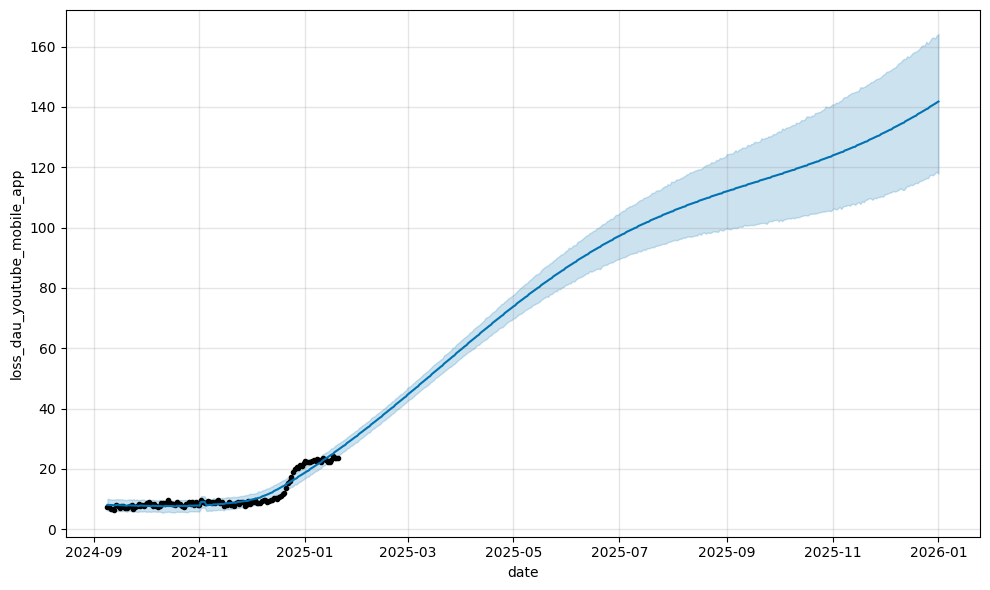

In [44]:
kpi = 'loss_dau_youtube_mobile_app'
date_start_dau_youtube = df_scaled_fin[~df_scaled_fin[kpi].eq(0)].index.min()
date_last_dau_youtube = df_scaled_fin[~df_scaled_fin[kpi].eq(0)].index.max()

model = Prophet(growth='linear',
            seasonality_mode='additive', 
            weekly_seasonality=True,
            holidays=holidays,
            yearly_seasonality=1, # 2 гармоники 
            seasonality_prior_scale=30)

data = df_scaled_fin.loc['2024-09-09':date_last_dau_youtube,].reset_index().rename(columns = {kpi: 'y', 'date': 'ds'})

model.fit(data)

date_diff = (pd.to_datetime('2026-01-01') - date_last_dau_youtube).days

future = model.make_future_dataframe(periods=date_diff)

# future['cap'] = trend(horizont)

forecast = model.predict(future)

# Визуализация результатов
fig = model.plot(forecast,ylabel=kpi,xlabel='date')
forecast.index = forecast.ds

In [45]:
date_forecast =  df_scaled_fin[~df_scaled_fin[kpi].eq(0)].index.max() + timedelta(days=1)
df_scaled_fin['loss_dau_youtube_mobile_app_prophet_mean'] = pd.concat([df_scaled_fin.loc[date_start_dau_youtube:date_last_dau_youtube,kpi],forecast['yhat'].loc[date_forecast:]])
df_scaled_fin['loss_dau_youtube_mobile_app_prophet_uci'] = pd.concat([df_scaled_fin.loc[date_start_dau_youtube:date_last_dau_youtube,kpi],forecast['yhat_upper'].loc[date_forecast:]])
df_scaled_fin['loss_dau_youtube_mobile_app_prophet_lci'] = pd.concat([df_scaled_fin.loc[date_start_dau_youtube:date_last_dau_youtube,kpi],forecast['yhat_lower'].loc[date_forecast:]])

In [46]:
df_scaled_fin['loss_dau_youtube_mobile_app_prophet_mean'].fillna(0,inplace=True)
df_scaled_fin['loss_dau_youtube_mobile_app_prophet_uci'].fillna(0,inplace=True)
df_scaled_fin['loss_dau_youtube_mobile_app_prophet_lci'].fillna(0,inplace=True)

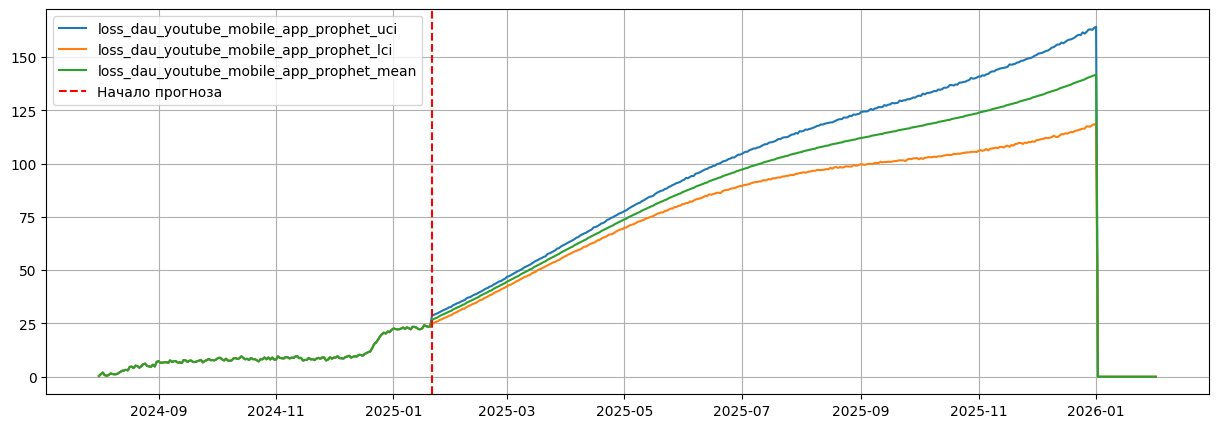

In [47]:
plt.figure(figsize=(15, 5))
plt.plot(df_scaled_fin[['loss_dau_youtube_mobile_app_prophet_uci','loss_dau_youtube_mobile_app_prophet_lci','loss_dau_youtube_mobile_app_prophet_mean']].loc[date_start_dau_youtube:])
plt.axvline(x=np.datetime64(date_forecast), color='red', linestyle='--', label='Начало прогноза')
plt.legend(['loss_dau_youtube_mobile_app_prophet_uci','loss_dau_youtube_mobile_app_prophet_lci','loss_dau_youtube_mobile_app_prophet_mean','Начало прогноза'])
plt.grid(True)
plt.show()

## Prediction SBA via Prophet

In [48]:
df_scaled_fin.ba_spontaneous_roll_kpi_percent_14_54_net

date
2022-01-01   0.000
2022-01-02   0.000
2022-01-03   0.000
2022-01-04   0.000
2022-01-05   0.000
              ... 
2026-01-28   0.000
2026-01-29   0.000
2026-01-30   0.000
2026-01-31   0.000
2026-02-01   0.000
Name: ba_spontaneous_roll_kpi_percent_14_54_net, Length: 1492, dtype: float64

In [49]:
kpi = 'ba_spontaneous_roll_kpi_percent_14_54_saa'

# df_scaled_fin['sba_lag7'] = df_scaled_fin.ba_spontaneous_roll_kpi_percent_14_54.shift(7)
# df_scaled_fin['sba_lag14'] = df_scaled_fin.ba_spontaneous_roll_kpi_percent_14_54.shift(14)
df_scaled_fin.fillna(0,inplace=True)
factors = [
            'const',
            # 'media_360_shows_total_flights_3_4_ots',
            # 'media_360_shows_5_flight_shift_10_days',
            # 'media_360_total_flight_3_ots_shift_10_days',
            # 'media_360_total_flight_4_ots_shift_10_days',
            # 'media_360_shows_total_flights_3_4_ots_shift_10_days',
            # 'media_360_shows_total_ots_flight_5_shift_10_days',
            'media_360_shows_for_sba',
            # 'media_360_shows_flights_3_4_5_ots_shift_10_days',
            # 'media_360_shows_total_ots_flight_5',
            # 'media_360_total_flight_4_ots_shift_1_week',
            # 'media_360_total_flight_3_ots_shift_3_weeks',
            'project_aso_app_store',
            # 'project_aso_google_play',
            # 'mqp_bloggers_tvt_30s_hours',
            'project_smm_ots',
            'loss_dau_youtube_mobile_app_prophet_uci',
            # 'project_pr_ots',
            # 'sba_lag7',
            # 'sba_lag14',
            # 'media_360_shows_shift_23_days',
          ]
date_start_sba = df_scaled_fin[~df_scaled_fin[kpi].eq(0)].index.min()
date_last_sba = df_scaled_fin[~df_scaled_fin[kpi].eq(0)].index.max()


y_train = df_scaled_fin.loc['2023-09-01':date_last_sba,kpi] # date_start_sba
X_train = df_scaled_fin.loc['2023-09-01':date_last_sba,factors] # date_start_sba

date_forecast = date_last_sba + timedelta(days=1)
y_future = df_scaled_fin.loc[date_forecast:,kpi]
X_future = df_scaled_fin.loc[date_forecast:,factors]

model_sba = sm.OLS(y_train, X_train, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(model_sba.summary())

# Predict
y_pred_future = model_sba.predict(X_future)
impact_media_5_flight = model_sba.params.media_360_shows_for_sba*X_train.media_360_shows_for_sba
sba_wo_media = y_train - np.where(impact_media_5_flight.index <= '2024-08-01',0, impact_media_5_flight)
df_scaled_fin['sba_wo_media'] = sba_wo_media
df_scaled_fin['sba_wo_media'].fillna(0,inplace=True)

y_pred_train = model_sba.fittedvalues
print('SMAPE on train: ', round(SMAPE(y_train, y_pred_train), 2), '%')

                                        OLS Regression Results                                       
Dep. Variable:     ba_spontaneous_roll_kpi_percent_14_54_saa   R-squared:                       0.932
Model:                                                   OLS   Adj. R-squared:                  0.932
Method:                                        Least Squares   F-statistic:                     916.0
Date:                                       Fri, 07 Mar 2025   Prob (F-statistic):          3.49e-231
Time:                                               13:43:36   Log-Likelihood:                 1494.4
No. Observations:                                        515   AIC:                            -2979.
Df Residuals:                                            510   BIC:                            -2958.
Df Model:                                                  4                                         
Covariance Type:                                         HAC                      

In [50]:
plot_decomposition(pd.concat([y_train,X_train],axis=1).fillna(0),model_sba,kpi_name=kpi)


In [51]:
kpi = 'ba_spontaneous_roll_kpi_percent_14_54_saa'
date_flight_start= '2024-09-02'
date_flight_end = '2024-10-06'

df_flowchart = pd.DataFrame({'date_start':[pd.to_datetime(date_flight_start)], 
                                             'date_end':[pd.to_datetime(date_flight_end)], 
                                             'budget':[0.]},
                             index=['tv_360_impact', 
                                    'radio_impact', 
                                    'ooh_360_impact',
                                    'digital_media_360_impact',
                                    'bloggers_360_impact',
                                    'tv_shows_impact',
                                    'digital_media_shows_impact',
                                    'bloggers_shows_impact',
                                    #------------------------------
                                    'media_360_shows_for_sba',
                                    'const',
                                    'project_aso_app_store',
                                    'project_smm_ots',
                                    'loss_dau_youtube_mobile_app_prophet_uci',
                                    ])
upd_params = pd.Series({
                        'tv_360_impact':model_sba.params.get('media_360_shows_for_sba'),
                        'radio_impact':model_sba.params.get('media_360_shows_for_sba'),
                        'ooh_360_impact':model_sba.params.get('media_360_shows_for_sba'),
                        'digital_media_360_impact':model_sba.params.get('media_360_shows_for_sba'),
                        'bloggers_360_impact':model_sba.params.get('media_360_shows_for_sba'),
                        #-------------------------------------------------------------------------------
                        'tv_shows_impact':model_sba.params.get('media_360_shows_for_sba'),
                        'digital_media_shows_impact':model_sba.params.get('media_360_shows_for_sba'),
                        'bloggers_shows_impact':model_sba.params.get('media_360_shows_for_sba'),
                        #-------------------------------------------------------------------------------
                        'media_360_shows_for_sba':model_sba.params.get('media_360_shows_for_sba'),
                        #-------------------------------------------------------------------------------
                        'const':model_sba.params.get('const'),
                        'project_aso_app_store':model_sba.params.get('project_aso_app_store'),
                        'project_smm_ots':model_sba.params.get('project_smm_ots'),
                        'loss_dau_youtube_mobile_app_prophet_uci':model.params.get('loss_dau_youtube_mobile_app_prophet_uci'),
                       })



In [52]:
media_impact_mean_nested = calculate_media_impact(df_scaled_fin,
             df_flow_init=df_flowchart,
             media_factors=['tv_360_impact',
                                    'radio_impact',
                                    'ooh_360_impact',
                                    'digital_media_360_impact',
                                    'bloggers_360_impact',
                                    'tv_shows_impact',
                                    'digital_media_shows_impact',
                                    'bloggers_shows_impact'],
             other_factors=[        'media_360_shows_for_sba',
                                    'const',
                                    'project_aso_app_store',
                                    'project_smm_ots',
                                    'loss_dau_youtube_mobile_app_prophet_uci',],
             target=kpi,
             model=model_sba,
             model_params=upd_params, 
             avg_over_period=True) # сумма
media_impact_mean_nested

Scenario without advertising campaign: 0.09062


date_start   date_end  budget  \
tv_360_impact                           2024-09-02 2024-10-06   0.000   
radio_impact                            2024-09-02 2024-10-06   0.000   
ooh_360_impact                          2024-09-02 2024-10-06   0.000   
digital_media_360_impact                2024-09-02 2024-10-06   0.000   
bloggers_360_impact                     2024-09-02 2024-10-06   0.000   
tv_shows_impact                         2024-09-02 2024-10-06   0.000   
digital_media_shows_impact              2024-09-02 2024-10-06   0.000   
bloggers_shows_impact                   2024-09-02 2024-10-06   0.000   
media_360_shows_for_sba                 2024-09-02 2024-10-06   0.000   
const                                   2024-09-02 2024-10-06   0.000   
project_aso_app_store                   2024-09-02 2024-10-06   0.000   
project_smm_ots                         2024-09-02 2024-10-06   0.000   
loss_dau_youtube_mobile_app_prophet_uci 2024-09-02 2024-10-06   0.000   
media_total                             2024-09-02 2024-10-06   0.000   

                                         target_fact  impact_weighted  \
tv_360_impact                                  0.126            0.011   
radio_impact                                   0.126            0.002   
ooh_360_impact                                 0.126            0.008   
digital_media_360_impact                       0.126            0.006   
bloggers_360_impact                            0.126            0.001   
tv_shows_impact                                0.126            0.005   
digital_media_shows_impact                     0.126            0.003   
bloggers_shows_impact                          0.126            0.000   
media_360_shows_for_sba                        0.126            0.029   
const                                          0.126            0.039   
project_aso_app_store                          0.126            0.013   
project_smm_ots                                0.126            0.005   
loss_dau_youtube_mobile_app_prophet_uci        0.126              NaN   
media_total                                    0.126            0.035   

                                         increment  share   CPA  coefficient  
tv_360_impact                                9.363  8.561 0.000        0.031  
radio_impact                                 1.563  1.539 0.000        0.031  
ooh_360_impact                               6.425  6.038 0.000        0.031  
digital_media_360_impact                     4.882  4.655 0.000        0.031  
bloggers_360_impact                          0.948  0.939 0.000        0.031  
tv_shows_impact                              3.749  3.613 0.000        0.031  
digital_media_shows_impact                   2.529  2.467 0.000        0.031  
bloggers_shows_impact                        0.051  0.051 0.000        0.031  
media_360_shows_for_sba                     29.925 23.033 0.000        0.031  
const                                       44.408 30.752 0.000        0.041  
project_aso_app_store                       11.678 10.457 0.000        0.061  
project_smm_ots                              3.830  3.688 0.000        0.025  
loss_dau_youtube_mobile_app_prophet_uci        NaN    NaN   NaN          NaN  
media_total                                 38.623 27.862 0.000          NaN

13:43:36 - cmdstanpy - INFO - Chain [1] start processing
13:43:37 - cmdstanpy - INFO - Chain [1] done processing


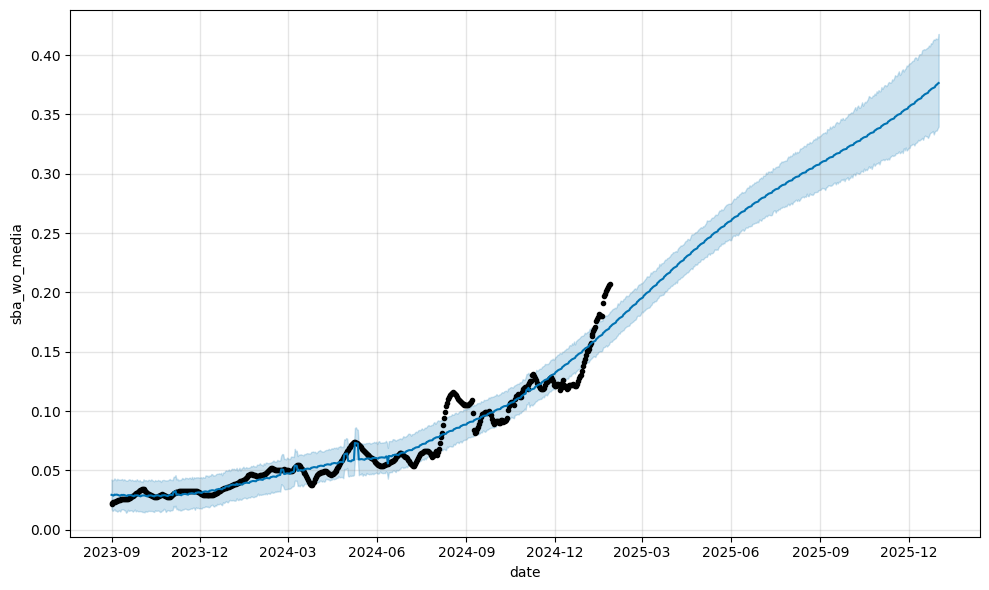

In [53]:
kpi = 'sba_wo_media'
# kpi = 'ba_spontaneous_roll_kpi_percent_14_44'
date_start_sba = df_scaled_fin[~df_scaled_fin[kpi].eq(0)].index.min()
date_last_sba = df_scaled_fin[~df_scaled_fin[kpi].eq(0)].index.max()

model = Prophet(growth='linear',
            seasonality_mode='additive', 
            weekly_seasonality=True,
            holidays=holidays,
            yearly_seasonality=1, # 2 гармоники 
            seasonality_prior_scale=30)

data = df_scaled_fin.loc[date_start_sba:date_last_sba,].reset_index().rename(columns = {kpi: 'y', 'date': 'ds'})

model.fit(data)

date_diff = (pd.to_datetime('2026-01-01') - date_last_sba).days

future = model.make_future_dataframe(periods=date_diff)

# future['cap'] = trend(horizont)

forecast = model.predict(future)

# Визуализация результатов
fig = model.plot(forecast,ylabel=kpi,xlabel='date')
forecast.index = forecast.ds

In [54]:
date_forecast =  df_scaled_fin[~df_scaled_fin[kpi].eq(0)].index.max() + timedelta(days=1)
df_scaled_fin['sba_prophet_mean_wo_media'] = pd.concat([df_scaled_fin.loc[date_start_sba:date_last_sba,kpi],forecast['yhat'].loc[date_forecast:]])
df_scaled_fin['sba_prophet_uci_wo_media'] = pd.concat([df_scaled_fin.loc[date_start_sba:date_last_sba,kpi],forecast['yhat_upper'].loc[date_forecast:]])
df_scaled_fin['sba_prophet_lci_wo_media'] = pd.concat([df_scaled_fin.loc[date_start_sba:date_last_sba,kpi],forecast['yhat_lower'].loc[date_forecast:]])

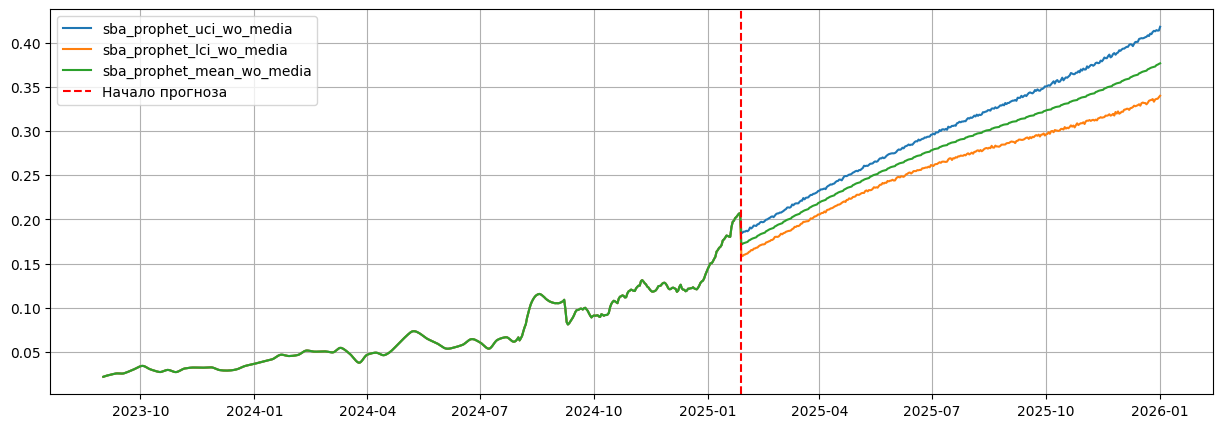

In [55]:
plt.figure(figsize=(15, 5))
plt.plot(df_scaled_fin[['sba_prophet_uci_wo_media','sba_prophet_lci_wo_media','sba_prophet_mean_wo_media']])
plt.axvline(x=np.datetime64(date_forecast), color='red', linestyle='--', label='Начало прогноза')
plt.legend(['sba_prophet_uci_wo_media','sba_prophet_lci_wo_media','sba_prophet_mean_wo_media','Начало прогноза'])
plt.grid(True)
plt.show()

## Prediction paid installs via Linear Regression

In [56]:
kpi = 'installs_paid_mobile_app'
date_start_paid_installs = df_scaled_fin[~df_scaled_fin[kpi].eq(0)].index.min()
date_last_paid_installs = df_scaled_fin[~df_scaled_fin[kpi].eq(0)].index.max()

In [57]:
df_scaled_fin[['installs_paid_mobile_app','installs_organic_mobile_app']].iplot()

In [58]:
factors = [
            'const',
            'digital_perf_spends',
            # 'media_360_shows_total_ots_flight_5',
            # 'media_360_shows_other_total_flight_5_ots',
            'media_360_shows_flights_3_4_5_ots',
            'project_aso_app_store',
            'project_aso_google_play',
          ]
date_train_start = date_start_paid_installs
date_train_end = date_last_paid_installs   # date_end_dau_saa # pd.to_datetime('2024-07-31')
y_train = df_scaled_fin.loc[date_train_start:date_train_end,kpi]
X_train = df_scaled_fin.loc[date_train_start:date_train_end,factors]

date_forecast = date_train_end + timedelta(days=1)
y_future = df_scaled_fin.loc[date_forecast:,kpi]
X_future = df_scaled_fin.loc[date_forecast:,factors]

model_paid = sm.OLS(y_train, X_train, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(model_paid.summary())

# Predict
y_pred_future = model_paid.predict(X_future)

y_pred_train = model_paid.fittedvalues
print('SMAPE on train: ', round(SMAPE(y_train, y_pred_train), 2), '%')

                               OLS Regression Results                               
Dep. Variable:     installs_paid_mobile_app   R-squared:                       0.803
Model:                                  OLS   Adj. R-squared:                  0.802
Method:                       Least Squares   F-statistic:                     12.60
Date:                      Fri, 07 Mar 2025   Prob (F-statistic):           5.71e-08
Time:                              13:43:37   Log-Likelihood:                -6039.3
No. Observations:                       542   AIC:                         1.209e+04
Df Residuals:                           537   BIC:                         1.211e+04
Df Model:                                 4                                         
Covariance Type:                        HAC                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

In [59]:
plot_decomposition(pd.concat([y_train,X_train],axis=1).fillna(0),model_paid,kpi_name=kpi)

In [60]:
kpi = 'installs_paid_mobile_app'
date_flight_start= '2024-09-02'
date_flight_end = '2024-10-06'

df_flowchart = pd.DataFrame({'date_start':[pd.to_datetime(date_flight_start)], 
                                             'date_end':[pd.to_datetime(date_flight_end)], 
                                             'budget':[0.]},
                             index=['tv_360_impact', 
                                    'ooh_360_impact',
                                    'digital_media_360_impact',
                                    'bloggers_360_impact',
                                    'radio_impact',
                                    #------------------------------
                                    'tv_shows_impact',
                                    'digital_media_shows_impact',
                                    'bloggers_shows_impact',
                                    #------------------------------
                                    'media_360_shows_flights_3_4_5_ots',
                                    'const',
                                    'digital_perf_spends',
                                    'project_aso_app_store',
                                    'project_aso_google_play'])
upd_params = pd.Series({
                        'tv_360_impact':model_paid.params.get('media_360_shows_flights_3_4_5_ots'),
                        'ooh_360_impact':model_paid.params.get('media_360_shows_flights_3_4_5_ots'),
                        'digital_media_360_impact':model_paid.params.get('media_360_shows_flights_3_4_5_ots'),
                        'bloggers_360_impact':model_paid.params.get('media_360_shows_flights_3_4_5_ots'),
                        'radio_impact':model_paid.params.get('media_360_shows_flights_3_4_5_ots'),
                        #-------------------------------------------------------------------------------
                        'tv_shows_impact':model_paid.params.get('media_360_shows_flights_3_4_5_ots'),
                        'digital_media_shows_impact':model_paid.params.get('media_360_shows_flights_3_4_5_ots'),
                        'bloggers_shows_impact':model_paid.params.get('media_360_shows_flights_3_4_5_ots'),
                        #-------------------------------------------------------------------------------
                        'media_360_shows_flights_3_4_5_ots':model_paid.params.get('media_360_shows_flights_3_4_5_ots'),
                        'const':model_paid.params.get('const'),
                        'digital_perf_spends':model_paid.params.get('digital_perf_spends'),
                        'project_aso_app_store':model_paid.params.get('project_aso_app_store'),
                        'project_aso_google_play':model_paid.params.get('project_aso_google_play'),
                       })

media_impact_mean_nested = calculate_media_impact(df_scaled_fin,
             df_flow_init=df_flowchart,
             media_factors=['tv_360_impact', 
                                    'ooh_360_impact',
                                    'digital_media_360_impact',
                                    'bloggers_360_impact',
                                    'radio_impact', 
                                    'tv_shows_impact',
                                    'digital_media_shows_impact',
                                    'bloggers_shows_impact',],
             other_factors=['media_360_shows_flights_3_4_5_ots',
                            'const',
                            'digital_perf_spends',
                            'project_aso_app_store',
                            'project_aso_google_play'],
             target=kpi,
             model=model_paid,
             model_params=upd_params, 
             avg_over_period=False) # сумма
media_impact_mean_nested

Scenario without advertising campaign: 2893674.95376


date_start   date_end  budget  target_fact  \
tv_360_impact                     2024-09-02 2024-10-06   0.000  3353922.000   
ooh_360_impact                    2024-09-02 2024-10-06   0.000  3353922.000   
digital_media_360_impact          2024-09-02 2024-10-06   0.000  3353922.000   
bloggers_360_impact               2024-09-02 2024-10-06   0.000  3353922.000   
radio_impact                      2024-09-02 2024-10-06   0.000  3353922.000   
tv_shows_impact                   2024-09-02 2024-10-06   0.000  3353922.000   
digital_media_shows_impact        2024-09-02 2024-10-06   0.000  3353922.000   
bloggers_shows_impact             2024-09-02 2024-10-06   0.000  3353922.000   
media_360_shows_flights_3_4_5_ots 2024-09-02 2024-10-06   0.000  3353922.000   
const                             2024-09-02 2024-10-06   0.000  3353922.000   
digital_perf_spends               2024-09-02 2024-10-06   0.000  3353922.000   
project_aso_app_store             2024-09-02 2024-10-06   0.000  3353922.000   
project_aso_google_play           2024-09-02 2024-10-06   0.000  3353922.000   
media_total                       2024-09-02 2024-10-06   0.000  3353922.000   

                                   impact_weighted  increment  share   CPA  \
tv_360_impact                           141425.723      4.402  4.217 0.000   
ooh_360_impact                           99733.726      3.065  2.974 0.000   
digital_media_360_impact                 76888.376      2.346  2.292 0.000   
bloggers_360_impact                      15509.599      0.465  0.462 0.000   
radio_impact                             25416.948      0.764  0.758 0.000   
tv_shows_impact                          59691.063      1.812  1.780 0.000   
digital_media_shows_impact               40744.721      1.230  1.215 0.000   
bloggers_shows_impact                      836.891      0.025  0.025 0.000   
media_360_shows_flights_3_4_5_ots       460244.681     15.905 13.723 0.000   
const                                   436104.055     14.946 13.003 0.000   
digital_perf_spends                    1669653.320     99.132 49.782 0.000   
project_aso_app_store                   280503.111      9.127  8.363 0.000   
project_aso_google_play                 507416.834     17.826 15.129 0.000   
media_total                             460247.046     15.905 13.723 0.000   

                                   coefficient  
tv_360_impact                        10944.090  
ooh_360_impact                       10944.090  
digital_media_360_impact             10944.090  
bloggers_360_impact                  10944.090  
radio_impact                         10944.090  
tv_shows_impact                      10944.090  
digital_media_shows_impact           10944.090  
bloggers_shows_impact                10944.090  
media_360_shows_flights_3_4_5_ots    10944.090  
const                                12541.748  
digital_perf_spends                      0.005  
project_aso_app_store                35534.663  
project_aso_google_play              54967.361  
media_total                                NaN

In [61]:
file_path = '../../results/sept_pba/paid_installs.xlsx'
df_scaled_fin.installs_paid_mobile_app.loc['2024-08-01':'2024-10-31'].to_excel(file_path)

res_paid_weeks = df_scaled_fin.installs_paid_mobile_app.loc['2024-08-01':'2024-10-31'].resample(rule='W-MON', label='left').sum()
res_paid_months = df_scaled_fin.installs_paid_mobile_app.loc['2024-08-01':'2024-10-31'].resample(rule='M', label='left').sum()
res_paid_months.index = res_paid_months.index + timedelta(days=1)

with pd.ExcelWriter(file_path, engine='openpyxl', mode='a') as writer:
    # Сохраняем датафрейм на отдельный лист в существующем файле
    res_paid_weeks.to_excel(writer, sheet_name='weeks')
    res_paid_months.to_excel(writer, sheet_name='months')
    media_impact_mean_nested.to_excel(writer, sheet_name='decompose_paid')


In [62]:
date_flight_start = pd.to_datetime('2024-09-02')
date_flight_end = pd.to_datetime('2024-10-06')
# date_flight_start = date_flight_end - timedelta(days=157)
pd.set_option('display.float_format', '{:.3f}'.format)
res = pd.DataFrame()
y_predict_flight = y_pred_train.loc[date_flight_start:date_flight_end]
tv_impact = upd_params.get('tv_360_impact')* df_scaled_fin['tv_360_impact'].loc[date_flight_start:date_flight_end]
share_tv_impact = tv_impact/y_predict_flight

tv_shows_impact = upd_params.get('tv_shows_impact')* df_scaled_fin['tv_shows_impact'].loc[date_flight_start:date_flight_end]
share_tv_shows_impact = tv_shows_impact/y_predict_flight

ooh_impact = upd_params.get('ooh_360_impact')* df_scaled_fin['ooh_360_impact'].loc[date_flight_start:date_flight_end]
share_ooh_impact = ooh_impact/y_predict_flight



digital_media_impact= upd_params.get('digital_media_360_impact')* df_scaled_fin['digital_media_360_impact'].loc[date_flight_start:date_flight_end]
share_digital_media_impact = digital_media_impact / y_predict_flight

digital_media_shows_impact = upd_params.get('digital_media_shows_impact')* df_scaled_fin['digital_media_shows_impact'].loc[date_flight_start:date_flight_end]
share_digital_media_shows_impact = digital_media_shows_impact / y_predict_flight


bloggers_impact = upd_params.get('bloggers_360_impact')* df_scaled_fin['bloggers_360_impact'].loc[date_flight_start:date_flight_end]
share_bloggers_impact = bloggers_impact / y_predict_flight


bloggers_shows_impact = upd_params.get('bloggers_shows_impact')* df_scaled_fin['bloggers_shows_impact'].loc[date_flight_start:date_flight_end]
share_bloggers_shows_impact = bloggers_shows_impact / y_predict_flight

radio_impact = upd_params.get('radio_impact')* df_scaled_fin['radio_impact'].loc[date_flight_start:date_flight_end]
share_radio_impact = radio_impact / y_predict_flight

res['tv_impact'] = share_tv_impact*y_train.loc[date_flight_start:date_flight_end]
res['tv_shows_impact'] = share_tv_shows_impact*y_train.loc[date_flight_start:date_flight_end]

res['ooh_impact'] = share_ooh_impact*y_train.loc[date_flight_start:date_flight_end]

res['digital_media_impact'] = share_digital_media_impact*y_train.loc[date_flight_start:date_flight_end]
res['digital_media_shows_impact'] = share_digital_media_shows_impact*y_train.loc[date_flight_start:date_flight_end]

res['bloggers_impact'] = share_bloggers_impact*y_train.loc[date_flight_start:date_flight_end]
res['bloggers_shows_impact'] = share_bloggers_shows_impact*y_train.loc[date_flight_start:date_flight_end]

res['radio_impact'] = share_radio_impact*y_train.loc[date_flight_start:date_flight_end]

factors_media = ['tv_impact','tv_shows_impact','ooh_impact', 
                 'digital_media_impact','digital_media_shows_impact', 'bloggers_impact','bloggers_shows_impact','radio_impact']

res['media_total_impact'] = res[factors_media].sum(axis=1)
res['media_total_impact_%'] = res['media_total_impact']/y_predict_flight

res['y_predict'] = y_predict_flight
res['y_fact'] = y_train
# группировка по неделям 
res_weeks = res.resample(rule='W-MON', label='left').sum()
res_weeks['media_total_impact_%'] = res_weeks['media_total_impact']/res_weeks.y_predict*100

# группировка по месяцам 
res_months = res.resample(rule='M', label='left').sum()
res_months['media_total_impact_%'] = res_months['media_total_impact']/res_months.y_predict*100
res_months.index = res_months.index + timedelta(days=1)

In [63]:
media_impact_mean_nested.to_excel('../../results/sept_pba/results_nested_paid_installs.xlsx', sheet_name='main')

In [64]:
paid_retention = pd.read_excel('../../data/retentions/vkvideo_retention_data_30+.xlsx',sheet_name='paid_retention')
paid_retention.set_index('date',inplace=True)
paid_retention.insert(0, '0', 1.)
mean_paid_retention = paid_retention.mean(axis=0)[:36]
date_forecast = pd.date_range(date_flight_start,date_flight_end)
dau_paid_forecast = {}
for j in factors_media:
    dau_paid_forecast[j] = []
    for i in date_forecast:
        start_date = i - timedelta(days=35)
        mean_paid_retention_reverse = mean_paid_retention[::-1]
        mean_paid_retention_reverse.index = pd.date_range(start_date,i)
        dau_i = (res[j].loc[start_date:i] * mean_paid_retention_reverse).sum()
        dau_paid_forecast[j].append(dau_i)
dau_paid_forecast = pd.DataFrame(dau_paid_forecast, index = date_forecast)

In [65]:
dau_paid_forecast.mean()

tv_impact                    7676.957
tv_shows_impact              3741.606
ooh_impact                   5510.608
digital_media_impact         4512.252
digital_media_shows_impact   2587.610
bloggers_impact               987.602
bloggers_shows_impact          50.174
radio_impact                 1860.535
dtype: float64

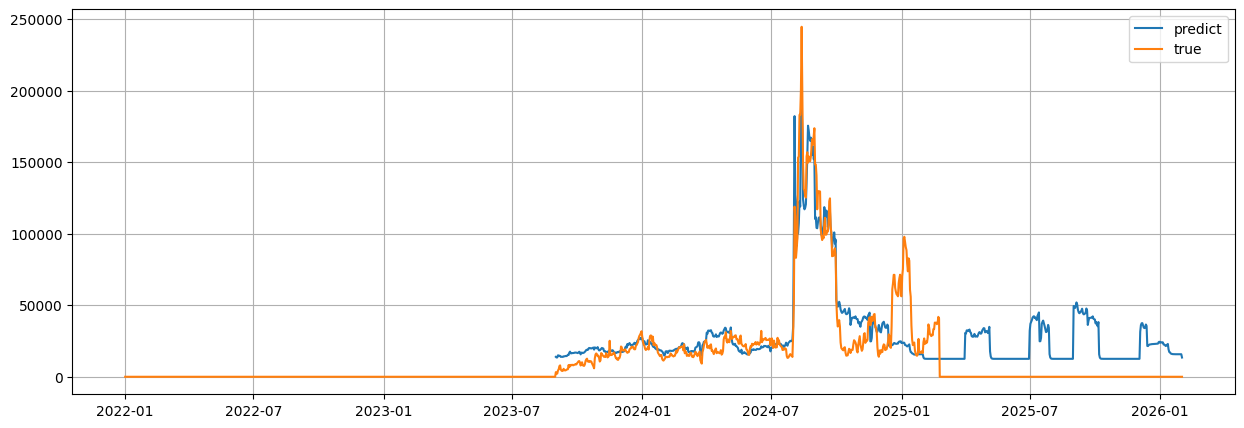

In [66]:
date_forecast =  df_scaled_fin[~df_scaled_fin[kpi].eq(0)].index.max() + timedelta(days=1)
df_scaled_fin['installs_paid_predict'] = pd.concat([y_pred_train,y_pred_future],axis=0)
plt.figure(figsize=(15,5))
plt.plot(df_scaled_fin[['installs_paid_predict','installs_paid_mobile_app']],label=['predict', 'true'])
plt.legend()
plt.grid(True)
plt.show()
df_scaled_fin['installs_paid_forecast'] = pd.concat([y_train,y_pred_future],axis=0)

In [67]:
df_scaled_fin['installs_paid_linear_pred'] = pd.concat([df_scaled_fin.loc[date_start_paid_installs:date_last_paid_installs,kpi],y_pred_future[date_last_paid_installs + timedelta(days=1):]])

In [68]:
df_scaled_fin['installs_total_predict'] = df_scaled_fin[['installs_growth_prophet_uci','installs_organic_prophet_uci','installs_paid_forecast']].sum(axis=1)
df_scaled_fin[['installs_organic_prophet_uci','installs_paid_forecast','installs_growth_prophet_uci','installs_total_predict']].to_excel('../../data/retentions/installs_predict.xlsx')

## Convertation installs to DAU through retention rate

In [69]:
organic_retention = pd.read_excel('../../data/retentions/vkvideo_retention_data_30+.xlsx',sheet_name='organic_retention')
paid_retention = pd.read_excel('../../data/retentions/vkvideo_retention_data_30+.xlsx',sheet_name='paid_retention')
growth_retention = pd.read_excel('../../data/retentions/vkvideo_retention_data_30+.xlsx',sheet_name='growth_retention')
# --------------------------------------------------------------------
organic_retention.set_index('date',inplace=True)
paid_retention.set_index('date',inplace=True)
growth_retention.set_index('date',inplace=True)
# --------------------------------------------------------------------
organic_retention.insert(0, '0', 1.)
paid_retention.insert(0, '0', 1.)
growth_retention.insert(0, '0', 1.)

In [70]:
# средние ретеншенов каждого дня
mean_organic_retention = organic_retention.mean(axis=0)
mean_growth_retention = growth_retention.mean(axis=0)
mean_paid_retention = paid_retention.mean(axis=0)

### Organic installs to DAU

In [71]:
date_forecast = pd.date_range(pd.to_datetime('2023-10-01'),pd.to_datetime('2024-12-31'))
dau_organic_forecast = []
for i in date_forecast:
    start_date = i - timedelta(days=157)
    mean_organic_installs_reverse = mean_organic_retention[::-1]
    mean_organic_installs_reverse.index = pd.date_range(start_date,i)
    dau_i = (df_scaled_fin.installs_organic_prophet_lci.loc[start_date:i] * mean_organic_installs_reverse).sum()
    dau_organic_forecast.append(dau_i)    

### Paid installs to DAU

In [72]:
date_forecast = pd.date_range(pd.to_datetime('2023-10-01'),pd.to_datetime('2024-12-31'))
dau_paid_forecast = []
for i in date_forecast:
    start_date = i - timedelta(days=157)
    mean_paid_installs_reverse = mean_paid_retention[::-1]
    mean_paid_installs_reverse.index = pd.date_range(start_date,i)
    dau_i = (df_scaled_fin.installs_paid_linear_pred.loc[start_date:i] * mean_paid_installs_reverse).sum()
    dau_paid_forecast.append(dau_i)    

### Growth installs to DAU

In [73]:
date_forecast = pd.date_range(pd.to_datetime('2023-10-01'),pd.to_datetime('2024-12-31'))
dau_growth_forecast = []
for i in date_forecast:
    start_date = i - timedelta(days=157)
    mean_growth_installs_reverse = mean_growth_retention[::-1]
    mean_growth_installs_reverse.index = pd.date_range(start_date,i)
    dau_i = (df_scaled_fin.installs_growth_prophet_lci.loc[start_date:i] * mean_growth_installs_reverse).sum()
    dau_growth_forecast.append(dau_i)

In [74]:
dau_forecast = pd.DataFrame({'dau_organic_forecast':dau_organic_forecast,
             'dau_growth_forecast':dau_growth_forecast,
             'dau_paid_forecast':dau_paid_forecast},index = date_forecast)

In [75]:
# for col in dau_forecast.columns.values:
#     dau_forecast[f'{col}_scaling'] = scaler.fit_transform(dau_forecast[col].values.reshape(-1, 1)) + 2

In [76]:
df_scaled_fin = df_scaled_fin.merge(dau_forecast, how='outer', left_index=True,right_index=True)

## DAU SAA

In [77]:
dau_paid_impact = df_scaled_fin.dau_paid_forecast.loc[date_flight_start:date_flight_end].mean()
dau_organic_impact = df_scaled_fin.dau_organic_forecast.loc[date_flight_start:date_flight_end].mean()
dau_growth_impact = df_scaled_fin.dau_growth_forecast.loc[date_flight_start:date_flight_end].mean()

In [78]:
dau_paid_impact, dau_organic_impact, dau_growth_impact

(419328.1931840741, 277544.1041540542, 71784.28165612249)

In [79]:
df_scaled_fin[['dau_organic_forecast','dau_growth_forecast','dau_paid_forecast']].iplot()

In [80]:
date_diff = (date_end_dau_saa+timedelta(days=1) - pd.to_datetime('2024-08-08')).days
log_space=np.logspace(start=0.5,stop=1.4, num=date_diff)
df_scaled_fin['log_rise'] = 0.
df_scaled_fin.loc['2024-08-08':date_end_dau_saa, 'log_rise'] =  np.sort(log_space)
df_scaled_fin.loc[date_end_dau_saa+timedelta(days=1):'2024-12-31','log_rise'] = log_space.max()
# ---------------------------------------------------------
df_scaled_fin['dau_from_installs'] = df_scaled_fin[['dau_organic_forecast','dau_growth_forecast','dau_paid_forecast']].sum(axis=1)
# ---------------------------------------------------------
df_scaled_fin['dau_from_organic_growth_installs'] = df_scaled_fin[['dau_organic_forecast','dau_growth_forecast']].sum(axis=1)
# ---------------------------------------------------------
weekly_range = pd.date_range(start='2024-09-01',end='2024-12-31', freq='w')
df_scaled_fin['seasonality_weekly_since_sept'] = 0.
df_scaled_fin['seasonality_weekly_since_sept'].loc[weekly_range] = 1.
# ---------------------------------------------------------
df_scaled_fin['installs_total_predict_adstock'] = adstock(df_scaled_fin['installs_total_predict'],decay_rate=0.8)
df_scaled_fin['ln_installs_total_predict_adstock'] = np.log1p(df_scaled_fin['installs_total_predict_adstock'])
# ---------------------------------------------------------
df_scaled_fin['mau-dau'] = df_scaled_fin.mau - df_scaled_fin.dau_saa
df_scaled_fin['dau/mau'] =  df_scaled_fin.dau_saa/df_scaled_fin.mau

df_scaled_fin['paid_installs_multi_loss_youtube'] = np.where(df_scaled_fin.loss_dau_youtube_mobile_app_prophet_uci==0 , df_scaled_fin['installs_paid_forecast'], df_scaled_fin['installs_paid_forecast'] * df_scaled_fin['loss_dau_youtube_mobile_app_prophet_uci'])
df_scaled_fin['paid_dau_multi_loss_youtube'] = np.where(df_scaled_fin.loss_dau_youtube_mobile_app_prophet_uci==0 , df_scaled_fin['dau_paid_forecast'], df_scaled_fin['dau_paid_forecast'] * df_scaled_fin['loss_dau_youtube_mobile_app_prophet_uci'])

df_scaled_fin['organic_dau_multi_loss_youtube'] = np.where(df_scaled_fin.loss_dau_youtube_mobile_app_prophet_uci==0 , df_scaled_fin['dau_organic_forecast'], df_scaled_fin['dau_organic_forecast'] * df_scaled_fin['loss_dau_youtube_mobile_app_prophet_uci'])
df_scaled_fin['growth_dau_multi_loss_youtube'] = np.where(df_scaled_fin.loss_dau_youtube_mobile_app_prophet_uci==0 , df_scaled_fin['dau_growth_forecast'], df_scaled_fin['dau_growth_forecast'] * df_scaled_fin['loss_dau_youtube_mobile_app_prophet_uci'])

df_scaled_fin['organic_growth_dau_multi_loss_youtube'] = np.where(df_scaled_fin.loss_dau_youtube_mobile_app_prophet_uci==0 , df_scaled_fin['dau_growth_forecast'] + df_scaled_fin['dau_organic_forecast'], (df_scaled_fin['dau_growth_forecast']+ df_scaled_fin['dau_organic_forecast']) * df_scaled_fin['loss_dau_youtube_mobile_app_prophet_uci'])

df_scaled_fin['organic_growth_installs_multi_loss_youtube'] = np.where(df_scaled_fin.loss_dau_youtube_mobile_app_prophet_uci==0 , df_scaled_fin['installs_growth_prophet_uci'] + df_scaled_fin['installs_organic_prophet_mean'], (df_scaled_fin['installs_growth_prophet_uci']+ df_scaled_fin['installs_organic_prophet_mean']) * df_scaled_fin['loss_dau_youtube_mobile_app_prophet_uci'])

# ---------------------------------------------------------
df_scaled_fin['installs_total_multi_loss_youtube'] = np.where(df_scaled_fin.loss_dau_youtube_mobile_app_prophet_uci==0 , df_scaled_fin['installs_total_predict'], df_scaled_fin['installs_total_predict'] * df_scaled_fin['loss_dau_youtube_mobile_app_prophet_uci'])
df_scaled_fin['dau_from_installs_multi_loss_youtube'] = np.where(df_scaled_fin.loss_dau_youtube_mobile_app_prophet_uci==0 , 0, df_scaled_fin['dau_from_installs'] * df_scaled_fin['loss_dau_youtube_mobile_app_prophet_uci'])

df_scaled_fin['multi_media_loss_dau_youtube'] = np.where(df_scaled_fin.loss_dau_youtube_mobile_app_prophet_uci==0 , df_scaled_fin['media_360_shows_total_ots_flight_5'], df_scaled_fin['media_360_shows_total_ots_flight_5'] * df_scaled_fin['loss_dau_youtube_mobile_app_prophet_uci'])

df_scaled_fin['paid_org_dau_multi_loss_youtube'] = df_scaled_fin[['paid_dau_multi_loss_youtube','organic_dau_multi_loss_youtube']].sum(axis=1)

df_scaled_fin['dummy_october'] = 0.

df_scaled_fin.loc['2024-10-01': ,'dummy_october'] = 1.

In [81]:
df_scaled_fin['dau_from_installs'].iplot()

In [82]:
factors = [
            # 'dummy_new_base_flight1',
            # 'dummy_new_base_flight2',
            # 'dummy_new_base_flight3',
            # 'dummy_new_base_flight4',
            'sba_prophet_mean_wo_media',
            # 'ba_spontaneous_roll_kpi_percent_14_44',
            # 'const',
            'loss_dau_youtube_mobile_app_prophet_lci',
            # 'dau_from_installs_multi_loss_youtube',
            # ----------------------------------
            # 'paid_installs_multi_loss_youtube',
            # 'paid_dau_multi_loss_youtube',
            # 'organic_dau_multi_loss_youtube',
            # 'paid_org_dau_multi_loss_youtube',
            # 'growth_dau_multi_loss_youtube',
            # 'organic_growth_installs_multi_loss_youtube',
            # 'dau_from_installs_multi_loss_youtube',
            # 'installs_total_multi_loss_youtube',
            # 'loss_youtube_prophet_lci',
            # 'rutube_loss_dau_mobile_app',
            # 'multi_loss_rutube_media',
            # 'rutube_loss_installs',
            'lin_rise_loss_rutube_from_android',
            # 'dummy_october',
            # 'multi_media_loss_dau_youtube',
            # 'rutube_loss_dau_mobile_app',
            # 'project_pr_ots',
            # 'project_smm_ots',
            # ----------------------------------
            'competitors_tv_total_ots',
            
            'media_360_shows_other_total_flight_5_ots',
            # 'media_shows_total_ots_flight_5',

            'seasonality_yearly',
            # 'seasonality_weekly',
            # 'seasonality_weekly_since_sept',
            # 'dau_youtube_prophet_uci',
            # 'sba_wo_media',
            # 'dummy_shock',
            # 'log_rise',
            # 'project_aso_app_store',
            # 'mqp_bloggers_tvt_30s_hours',
            # 'const',
            # 'media_360_total_flight_1_2_ots',
           # 'media_360_shows_ots_3_4_flight',
           # 'media_other_total_ots',
            # 'media_360_total_flights_3_4_5_ots',
            # 'media_360_shows_others_flights_3_4_5_ots',
            # 'dau_organic_forecast',
            # 'dau_growth_forecast',
            # 'dau_from_organic_growth_installs',
            # 'dau_paid_forecast',
            # 'mi_vk_fest_ots',
            # 'mi_vkontakte_ots',
            'dau_from_installs',
            # 'project_aso_app_store',
            # 'digital_perf_spends',
            # 'installs_growth_prophet_uci',
            # 'installs_organic_prophet_mean',
            # 'installs_paid_forecast',
          #  'installs_total_predict',
            # 'installs_total_predict_adstock',
            # 'ln_installs_total_predict_adstock'
          ]
kpi = 'dau_saa'
date_train_start = pd.to_datetime('2024-01-01')  #date_start_dau_saa
date_train_end = pd.to_datetime('2024-10-25') #date_end_dau_saa
y_train = df_scaled_fin.loc[date_train_start:date_train_end,kpi].fillna(0)
X_train = df_scaled_fin.loc[date_train_start:date_train_end,factors].fillna(0)


date_forecast = date_train_end + timedelta(days=1)
y_future = df_scaled_fin.loc[date_forecast:,kpi]
X_future = df_scaled_fin.loc[date_forecast:,factors]

model = sm.OLS(y_train, X_train, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(model.summary())

# Predict
y_pred_future = model.predict(X_future)

y_pred_train = model.fittedvalues
print('SMAPE on train: ', round(SMAPE(y_train, y_pred_train), 2), '%')

                                 OLS Regression Results                                
Dep. Variable:                dau_saa   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              1043.
Date:                Fri, 07 Mar 2025   Prob (F-statistic):                   6.02e-194
Time:                        13:43:38   Log-Likelihood:                         -3651.5
No. Observations:                 299   AIC:                                      7317.
Df Residuals:                     292   BIC:                                      7343.
Df Model:                           7                                                  
Covariance Type:                  HAC                                                  
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------

In [83]:
plot_decomposition(pd.concat([y_train,X_train],axis=1).fillna(0),model,kpi_name=kpi)

### Save model

In [84]:
pd.to_pickle(model,'../../models/sep_pba/dau_saa_sept_flight.pkl')

### Forecast

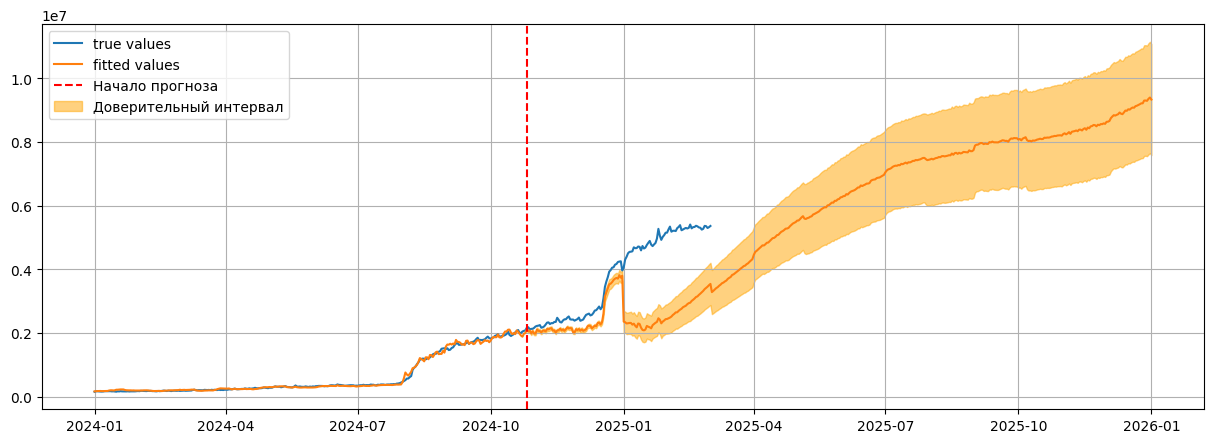

In [85]:
# Рассчитываем прогноз
forecast = model.get_prediction(X_future)

# Точечный рогноз
forecast_values = forecast.predicted_mean
# Интервальный прогноз (доверительный интервал)
forecast_intervals = forecast.conf_int()

plt.figure(figsize=(15, 5))
true_values = pd.concat([y_train,y_future[~y_future.eq(0)]],axis=0)
pred_values = pd.concat([y_pred_train,y_pred_future],axis=0)
plt.plot(true_values,label='true values')
plt.plot(pred_values,label='fitted values')
plt.axvline(x=np.datetime64(date_forecast), color='red', linestyle='--', label='Начало прогноза')
plt.fill_between(y_future.index, forecast_intervals[:, 0], forecast_intervals[:, 1], color='orange', alpha=0.5, label='Доверительный интервал')
plt.legend()
plt.grid(True)
plt.show()

### Nested regression for decopsotion multiplicative effect with installs and loss youtube

In [86]:
kpi = 'ln_dau_from_installs_multi_loss_youtube'

df_scaled_fin[kpi] = np.log1p(df_scaled_fin.dau_from_installs_multi_loss_youtube)
df_scaled_fin['ln_dau_paid_forecast']=  np.log1p(df_scaled_fin.dau_paid_forecast)
df_scaled_fin['ln_dau_from_installs']=  np.log1p(df_scaled_fin.dau_from_installs)
df_scaled_fin['ln_loss_dau_youtube_mobile_app_prophet_lci'] = np.log1p(df_scaled_fin.loss_dau_youtube_mobile_app_prophet_lci)
date_train_start = df_scaled_fin[~df_scaled_fin.dau_from_installs_multi_loss_youtube.eq(0)].dau_from_installs_multi_loss_youtube.index.min()
date_train_end = '2024-10-06'
factors = [
           'ln_dau_from_installs',
           'ln_loss_dau_youtube_mobile_app_prophet_lci']
y_train = df_scaled_fin.loc[date_train_start:date_train_end,kpi].fillna(0)
X_train = df_scaled_fin.loc[date_train_start:date_train_end,factors].fillna(0)

model_nested = sm.OLS(y_train, X_train, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(model_nested.summary())

y_pred_train = model_nested.fittedvalues
print('SMAPE on train: ', round(SMAPE(y_train, y_pred_train), 2), '%')

                                           OLS Regression Results                                           
Dep. Variable:     ln_dau_from_installs_multi_loss_youtube   R-squared (uncentered):                   1.000
Model:                                                 OLS   Adj. R-squared (uncentered):              1.000
Method:                                      Least Squares   F-statistic:                          1.371e+06
Date:                                     Fri, 07 Mar 2025   Prob (F-statistic):                   4.84e-151
Time:                                             13:43:39   Log-Likelihood:                          61.427
No. Observations:                                       67   AIC:                                     -118.9
Df Residuals:                                           65   BIC:                                     -114.4
Df Model:                                                2                                                  
Covariance Type:   

In [87]:
plot_decomposition(pd.concat([y_train,X_train],axis=1).fillna(0),model_nested,kpi_name=kpi)

In [88]:
date_flight_start= '2024-09-01'
date_flight_end = '2024-10-06'
df_flowchart = pd.DataFrame({'date_start':[pd.to_datetime(date_flight_start)], 
                                             'date_end':[pd.to_datetime(date_flight_end)], 
                                             'budget':[0.]},
                             index=['ln_dau_from_installs','ln_loss_dau_youtube_mobile_app_prophet_lci'])
upd_params = pd.Series({
                        'ln_dau_from_installs':model_nested.params.get('ln_dau_from_installs'),
                        'ln_loss_dau_youtube_mobile_app_prophet_lci':model_nested.params.get('ln_loss_dau_youtube_mobile_app_prophet_lci'),
                       })

media_impact_mean_nested = calculate_media_impact(df_scaled_fin,
             df_flow_init=df_flowchart,
             media_factors=['ln_dau_from_installs','ln_loss_dau_youtube_mobile_app_prophet_lci'],
             other_factors=[],
             target=kpi,
             model=model_nested,
             model_params=upd_params,
             avg_over_period=True) # сумма
media_impact_mean_nested

Scenario without advertising campaign: -0.0


date_start   date_end  budget  \
ln_dau_from_installs                       2024-09-01 2024-10-06   0.000   
ln_loss_dau_youtube_mobile_app_prophet_lci 2024-09-01 2024-10-06   0.000   
media_total                                2024-09-01 2024-10-06   0.000   

                                            target_fact  impact_weighted  \
ln_dau_from_installs                             15.556           12.491   
ln_loss_dau_youtube_mobile_app_prophet_lci       15.556            3.065   
media_total                                      15.556           15.556   

                                                         increment   share  \
ln_dau_from_installs                                       407.499  80.296   
ln_loss_dau_youtube_mobile_app_prophet_lci                  24.540  19.704   
media_total                                -875735649601685632.000 100.000   

                                             CPA  coefficient  
ln_dau_from_installs                       0.000        0.924  
ln_loss_dau_youtube_mobile_app_prophet_lci 0.000        1.442  
media_total                                0.000          NaN

In [89]:
media_impact_mean_nested.to_excel('../../results/sept_pba/results_multi_nested.xlsx', sheet_name='main')

###  Media impact for last flight (fifth)

In [90]:
kpi = 'dau_saa'
date_flight_start= '2024-09-02'
date_flight_end = '2024-10-06'
# Создадим новые колонки для разделения мультипликативного эффекта
share_paid_dau = df_scaled_fin['dau_paid_forecast'] / df_scaled_fin[['dau_organic_forecast',
                                                                     'dau_paid_forecast',
                                                                     'dau_growth_forecast']].sum(axis=1)

share_organic_dau = df_scaled_fin['dau_organic_forecast'] / df_scaled_fin[['dau_organic_forecast',
                                                                     'dau_paid_forecast',
                                                                     'dau_growth_forecast']].sum(axis=1)

share_growth_dau = df_scaled_fin['dau_growth_forecast'] / df_scaled_fin[['dau_organic_forecast',
                                                                     'dau_paid_forecast',
                                                                     'dau_growth_forecast']].sum(axis=1)


df_scaled_fin['multi_paid_dau'] = df_scaled_fin.dau_from_installs_multi_loss_youtube * media_impact_mean_nested.loc['ln_dau_from_installs','share']/100*share_paid_dau
df_scaled_fin['multi_organic_dau'] = df_scaled_fin.dau_from_installs_multi_loss_youtube * media_impact_mean_nested.loc['ln_dau_from_installs','share']/100*share_organic_dau
df_scaled_fin['multi_growth_dau'] = df_scaled_fin.dau_from_installs_multi_loss_youtube * media_impact_mean_nested.loc['ln_dau_from_installs','share']/100*share_growth_dau
df_scaled_fin['multi_loss_dau_youtube'] = df_scaled_fin.dau_from_installs_multi_loss_youtube * media_impact_mean_nested.loc['ln_loss_dau_youtube_mobile_app_prophet_lci','share']/100

df_flowchart = pd.DataFrame({'date_start':[pd.to_datetime(date_flight_start)], 
                                             'date_end':[pd.to_datetime(date_flight_end)], 
                                             'budget':[0.]},
                             index=['tv_360_impact', 
                                    'ooh_360_impact',
                                    'digital_media_360_impact',
                                    'bloggers_360_impact',
                                    'radio_impact',
                                    'tv_shows_impact',
                                    'digital_media_shows_impact',
                                    'bloggers_shows_impact',
                                    #------------------------------
                                    'media_360_shows_other_total_flight_5_ots',
                                    
                                    'sba_prophet_mean_wo_media',
                                    # 'dummy_october', 
                                    'lin_rise_loss_rutube_from_android',
                                    'loss_dau_youtube_mobile_app_prophet_lci',
                                    # 'project_smm_ots',
                                    # 'dau_from_installs_multi_loss_youtube',
                                    # 'multi_paid_dau',
                                    # 'multi_organic_dau',
                                    # 'multi_growth_dau',
                                    # 'multi_loss_dau_youtube',
                                    'dau_organic_forecast',
                                    'dau_growth_forecast',
                                    'dau_paid_forecast',
                                    'competitors_tv_total_ots',
                                    'seasonality_yearly',
                                    # 'seasonality_weekly',
                                    ])
upd_params = pd.Series({
                        'tv_360_impact':model.params.get('media_360_shows_other_total_flight_5_ots'),
                        'ooh_360_impact':model.params.get('media_360_shows_other_total_flight_5_ots'),
                        'digital_media_360_impact':model.params.get('media_360_shows_other_total_flight_5_ots'),
                        'bloggers_360_impact':model.params.get('media_360_shows_other_total_flight_5_ots'),
                        'radio_impact':model.params.get('media_360_shows_other_total_flight_5_ots'),
                        #-------------------------------------------------------------------------------
                        'tv_shows_impact':model.params.get('media_360_shows_other_total_flight_5_ots'),
                        'digital_media_shows_impact':model.params.get('media_360_shows_other_total_flight_5_ots'),
                        'bloggers_shows_impact':model.params.get('media_360_shows_other_total_flight_5_ots'),
                        #-------------------------------------------------------------------------------
                        'media_360_shows_other_total_flight_5_ots':model.params.get('media_360_shows_other_total_flight_5_ots'),
                        #-------------------------------------------------------------------------------
                        'sba_prophet_mean_wo_media':model.params.get('sba_prophet_mean_wo_media'),
                        # 'dummy_october':model.params.get('dummy_october'),
                        'lin_rise_loss_rutube_from_android':model.params.get('lin_rise_loss_rutube_from_android'),
                        'loss_dau_youtube_mobile_app_prophet_lci':model.params.get('loss_dau_youtube_mobile_app_prophet_lci'),
                        # 'project_smm_ots':model.params.get('project_smm_ots'),
                        #-------------------------------------------------------------------------------
                        # 'dau_from_installs_multi_loss_youtube':model.params.get('dau_from_installs_multi_loss_youtube'),
                        # 'multi_paid_dau':model.params.get('dau_from_installs_multi_loss_youtube'),
                        # 'multi_organic_dau':model.params.get('dau_from_installs_multi_loss_youtube'),
                        # 'multi_growth_dau':model.params.get('dau_from_installs_multi_loss_youtube'),
                        # 'multi_loss_dau_youtube':model.params.get('dau_from_installs_multi_loss_youtube'),
                        #-------------------------------------------------------------------------------
                        'dau_organic_forecast':model.params.get('dau_from_installs'),
                        'dau_growth_forecast':model.params.get('dau_from_installs'),
                     #    'dau_organic_forecast':model.params.get('dau_organic_forecast'),
                        'dau_paid_forecast':model.params.get('dau_from_installs'),
                        'competitors_tv_total_ots':model.params.get('competitors_tv_total_ots'),
                        'seasonality_yearly':model.params.get('seasonality_yearly'),
                        # 'seasonality_weekly':model.params.get('seasonality_weekly'),
                       })

In [91]:
tv_spends = df['tv_nat_spends'].loc[date_flight_start:date_flight_end].sum() 
tv_shows_spends = df['tv_nat_shows_spends'].loc[date_flight_start:date_flight_end].sum() 
ooh_spends = df[['ooh_spends', 'media_facades_spends',
                     'metro_mcc_spends','universities_spends',
                     'trains_spends','cinemas_spends','fitness_spends',
                     'airports_spends','molls_spends']].loc[date_flight_start:date_flight_end].sum(axis=1).sum()
digital_media_spends = df.digital_media_total_spends.loc[date_flight_start:date_flight_end].sum()
# -----------
digital_media_shows_spends = df.digital_media_shows_spends.loc[date_flight_start:date_flight_end].sum()
bloggers_shows_spends = df.bloggers_shows_spends.loc[date_flight_start:date_flight_end].sum()
# -----------
bloggers_spends = df['bloggers_spends'].loc[date_flight_start:date_flight_end].sum()
project_digital_spends = df['project_digital_spends'].loc[date_flight_start:date_flight_end].sum()

radio_spends = df['radio_spends'].loc[date_flight_start:date_flight_end].sum()
df_flowchart['budget'] = [tv_spends, ooh_spends, digital_media_spends,bloggers_spends, radio_spends,                      
                         tv_shows_spends, digital_media_shows_spends, bloggers_shows_spends
                         ] + 9*[0]

In [92]:
media_impact_mean = calculate_media_impact(df_scaled_fin,
             df_flow_init=df_flowchart,
             media_factors=['tv_360_impact', 
                                    'ooh_360_impact',
                                    'digital_media_360_impact',
                                    'bloggers_360_impact',
                                    'radio_impact',
                                    'tv_shows_impact',
                                    'digital_media_shows_impact',
                                    'bloggers_shows_impact'],
             other_factors=[        'media_360_shows_other_total_flight_5_ots',
                                    'sba_prophet_mean_wo_media',
                                    # 'dummy_october',
                                    'lin_rise_loss_rutube_from_android',
                                    'loss_dau_youtube_mobile_app_prophet_lci',
                                    # 'project_smm_ots',
                                    # 'dau_from_installs_multi_loss_youtube',
                                    # 'multi_paid_dau',
                                    # 'multi_organic_dau',
                                    # 'multi_growth_dau',
                                    # 'multi_loss_dau_youtube',
                                    'dau_organic_forecast',
                                    'dau_growth_forecast',
                                    'dau_paid_forecast',
                                    'competitors_tv_total_ots',
                                    'seasonality_yearly',
                                    # 'seasonality_weekly',
                                    ],
             target=kpi,
             model=model,
             model_params=upd_params,
             avg_over_period=True) # сумма
media_impact_mean

Scenario without advertising campaign: 1542842.18301


date_start   date_end        budget  \
tv_360_impact                            2024-09-02 2024-10-06 198763188.790   
ooh_360_impact                           2024-09-02 2024-10-06 178906234.080   
digital_media_360_impact                 2024-09-02 2024-10-06  72269418.000   
bloggers_360_impact                      2024-09-02 2024-10-06  21115812.000   
radio_impact                             2024-09-02 2024-10-06  13277991.000   
tv_shows_impact                          2024-09-02 2024-10-06  73364913.450   
digital_media_shows_impact               2024-09-02 2024-10-06  43555089.000   
bloggers_shows_impact                    2024-09-02 2024-10-06  16756061.000   
media_360_shows_other_total_flight_5_ots 2024-09-02 2024-10-06         0.000   
sba_prophet_mean_wo_media                2024-09-02 2024-10-06         0.000   
lin_rise_loss_rutube_from_android        2024-09-02 2024-10-06         0.000   
loss_dau_youtube_mobile_app_prophet_lci  2024-09-02 2024-10-06         0.000   
dau_organic_forecast                     2024-09-02 2024-10-06         0.000   
dau_growth_forecast                      2024-09-02 2024-10-06         0.000   
dau_paid_forecast                        2024-09-02 2024-10-06         0.000   
competitors_tv_total_ots                 2024-09-02 2024-10-06         0.000   
seasonality_yearly                       2024-09-02 2024-10-06         0.000   
media_total                              2024-09-02 2024-10-06 618008707.320   

                                          target_fact  impact_weighted  \
tv_360_impact                             1734364.429        58851.376   
ooh_360_impact                            1734364.429        41502.118   
digital_media_360_impact                  1734364.429        31995.500   
bloggers_360_impact                       1734364.429         6453.997   
radio_impact                              1734364.429        10576.735   
tv_shows_impact                           1734364.429        24839.196   
digital_media_shows_impact                1734364.429        16955.069   
bloggers_shows_impact                     1734364.429          348.255   
media_360_shows_other_total_flight_5_ots  1734364.429       191522.246   
sba_prophet_mean_wo_media                 1734364.429       -74585.647   
lin_rise_loss_rutube_from_android         1734364.429        18509.283   
loss_dau_youtube_mobile_app_prophet_lci   1734364.429       598740.579   
dau_organic_forecast                      1734364.429       369609.235   
dau_growth_forecast                       1734364.429        95596.098   
dau_paid_forecast                         1734364.429       558425.023   
competitors_tv_total_ots                  1734364.429       -61535.060   
seasonality_yearly                        1734364.429        38082.672   
media_total                               1734364.429       191522.246   

                                          increment  share      CPA  \
tv_360_impact                                 3.512  3.393   96.496   
ooh_360_impact                                2.452  2.393  123.165   
digital_media_360_impact                      1.879  1.845   64.535   
bloggers_360_impact                           0.374  0.372   93.478   
radio_impact                                  0.614  0.610   35.868   
tv_shows_impact                               1.453  1.432   84.388   
digital_media_shows_impact                    0.987  0.978   73.396   
bloggers_shows_impact                         0.020  0.020 1374.696   
media_360_shows_other_total_flight_5_ots     12.414 11.043    0.000   
sba_prophet_mean_wo_media                    -4.123 -4.300   -0.000   
lin_rise_loss_rutube_from_android             1.079  1.067    0.000   
loss_dau_youtube_mobile_app_prophet_lci      52.723 34.522    0.000   
dau_organic_forecast                         27.082 21.311    0.000   
dau_growth_forecast                           5.833  5.512    0.000   
dau_paid_forecast                            47.

In [93]:
df_scaled_fin[['installs_growth_mobile_app','installs_organic_mobile_app','installs_paid_mobile_app']].loc['2024-09-02':'2024-10-06'].sum()

installs_growth_mobile_app      383469
installs_organic_mobile_app    1391247
installs_paid_mobile_app       3353922
dtype: int64

In [94]:
filepath = '../../results/sept_pba/results_dau_saa.xlsx'
media_impact_mean.to_excel(filepath, sheet_name='main')

### Media impact in dynamics

In [95]:
date_flight_start = pd.to_datetime('2024-09-02')
date_flight_end = pd.to_datetime('2024-10-06')
# date_flight_start = date_flight_end - timedelta(days=157)
pd.set_option('display.float_format', '{:.3f}'.format)
res = pd.DataFrame()
y_predict_flight = y_pred.loc[date_flight_start:date_flight_end]
tv_impact = upd_params.get('tv_360_impact')* df_scaled_fin['tv_360_impact'].loc[date_flight_start:date_flight_end]
share_tv_impact = tv_impact/y_predict_flight

tv_shows_impact = upd_params.get('tv_shows_impact')* df_scaled_fin['tv_shows_impact'].loc[date_flight_start:date_flight_end]
share_tv_shows_impact = tv_shows_impact/y_predict_flight


ooh_impact = upd_params.get('ooh_360_impact')* df_scaled_fin['ooh_360_impact'].loc[date_flight_start:date_flight_end]
share_ooh_impact = ooh_impact/y_predict_flight



digital_media_impact= upd_params.get('digital_media_360_impact')* df_scaled_fin['digital_media_360_impact'].loc[date_flight_start:date_flight_end]
share_digital_media_impact = digital_media_impact / y_predict_flight

digital_media_shows_impact = upd_params.get('digital_media_shows_impact')* df_scaled_fin['digital_media_shows_impact'].loc[date_flight_start:date_flight_end]
share_digital_media_shows_impact = digital_media_shows_impact / y_predict_flight


bloggers_impact = upd_params.get('bloggers_360_impact')* df_scaled_fin['bloggers_360_impact'].loc[date_flight_start:date_flight_end]
share_bloggers_impact = bloggers_impact / y_predict_flight


bloggers_shows_impact = upd_params.get('bloggers_shows_impact')* df_scaled_fin['bloggers_shows_impact'].loc[date_flight_start:date_flight_end]
share_bloggers_shows_impact = bloggers_shows_impact / y_predict_flight

radio_impact = upd_params.get('radio_impact')* df_scaled_fin['radio_impact'].loc[date_flight_start:date_flight_end]
share_radio_impact = radio_impact / y_predict_flight


loss_rutube = upd_params.get('lin_rise_loss_rutube_from_android')* df_scaled_fin['lin_rise_loss_rutube_from_android'].loc[date_flight_start:date_flight_end]
share_loss_rutube = loss_rutube/y_predict_flight


res['tv_impact'] = share_tv_impact*y.loc[date_flight_start:date_flight_end]
res['tv_shows_impact'] = share_tv_shows_impact*y.loc[date_flight_start:date_flight_end]

res['ooh_impact'] = share_ooh_impact*y.loc[date_flight_start:date_flight_end]

res['digital_media_impact'] = share_digital_media_impact*y.loc[date_flight_start:date_flight_end]
res['digital_media_shows_impact'] = share_digital_media_shows_impact*y.loc[date_flight_start:date_flight_end]

res['bloggers_impact'] = share_bloggers_impact*y.loc[date_flight_start:date_flight_end]
res['bloggers_shows_impact'] = share_bloggers_shows_impact*y.loc[date_flight_start:date_flight_end]

res['radio_impact'] = share_radio_impact*y.loc[date_flight_start:date_flight_end]

factors_media = ['tv_impact','tv_shows_impact','ooh_impact', 
                 'digital_media_impact','digital_media_shows_impact', 'bloggers_impact','bloggers_shows_impact','radio_impact']

res['media_total_impact'] = res[factors_media].sum(axis=1)
res['media_total_impact_%'] = res['media_total_impact']/y_predict_flight

res['y_predict'] = y_predict_flight
res['y_fact'] = y
# группировка по неделям 
res_weeks = res.resample(rule='W-MON', label='left').sum()
res_weeks['media_total_impact_%'] = res_weeks['media_total_impact']/res_weeks.y_predict*100

# группировка по месяцам 
res_months = res.resample(rule='M', label='left').sum()
res_months['media_total_impact_%'] = res_months['media_total_impact']/res_months.y_predict*100
res_months.index = res_months.index + timedelta(days=1)

### Target metrics statistics

In [96]:
df_scaled_fin['tvt_net/dau_net'] = df_scaled_fin.tvt_net/df_scaled_fin.dau_net
df_scaled_fin['tvt_saa/dau_saa'] = df_scaled_fin.tvt_saa/df_scaled_fin.dau_saa

kpi_months = df_scaled_fin[['dau_saa','dau_net','tvt_saa','tvt_net','tvt_net/dau_net', 'tvt_saa/dau_saa', 'installs_organic_mobile_app']].resample(rule='M', label='left').agg({
    'dau_saa':np.mean,
    'dau_net':np.mean,
    'tvt_saa':np.mean,
    'tvt_net':np.mean,
    'tvt_net/dau_net':np.mean,
    'tvt_saa/dau_saa':np.mean,
    'installs_organic_mobile_app':np.sum
})
kpi_months.index = kpi_months.index + timedelta(days=1)

In [97]:
kpi_months.loc[:'2024-10-01'].to_excel('../../results/sept_pba/kpi_months.xlsx')

### Calculation of proxy contribution to TVT SAA

In [98]:
res_tvt = pd.DataFrame()
res_tvt['tvt_saa_per_user'] = (df_sc_fin.tvt_saa/ df_scaled_fin.dau_saa).loc[date_flight_start:date_flight_end]
res_tvt['tvt_saa'] = df_sc_fin.tvt_saa
res_tvt['tv_impact_tvt'] = res_tvt['tvt_saa_per_user'] * res.tv_impact
res_tvt['tv_shows_impact_tvt'] = res_tvt['tvt_saa_per_user'] * res.tv_shows_impact
res_tvt['ooh_impact_tvt'] = res_tvt['tvt_saa_per_user'] * res.ooh_impact
res_tvt['digital_media_impact_tvt'] = res_tvt['tvt_saa_per_user'] * res.digital_media_impact
res_tvt['digital_media_shows_impact_tvt'] = res_tvt['tvt_saa_per_user'] * res.digital_media_shows_impact
res_tvt['bloggers_impact_tvt'] = res_tvt['tvt_saa_per_user'] * res.bloggers_impact
res_tvt['bloggers_shows_impact_tvt'] = res_tvt['tvt_saa_per_user'] * res.bloggers_shows_impact
res_tvt['media_total_impact_tvt'] = res_tvt['tvt_saa_per_user'] * res.media_total_impact
res_tvt['media_total_impact_tvt_%'] = res_tvt['media_total_impact_tvt']/res_tvt['tvt_saa']

### Save results

In [99]:
with pd.ExcelWriter(filepath, engine='openpyxl', mode='a') as writer:
    # Сохраняем датафрейм на отдельный лист в существующем файле
    res.to_excel(writer, sheet_name='decompose_days')
    res_weeks.to_excel(writer, sheet_name='decompose_weeks')
    res_months.to_excel(writer, sheet_name='decompose_months')

### Prophet

13:49:00 - cmdstanpy - INFO - Chain [1] start processing
13:49:00 - cmdstanpy - INFO - Chain [1] done processing


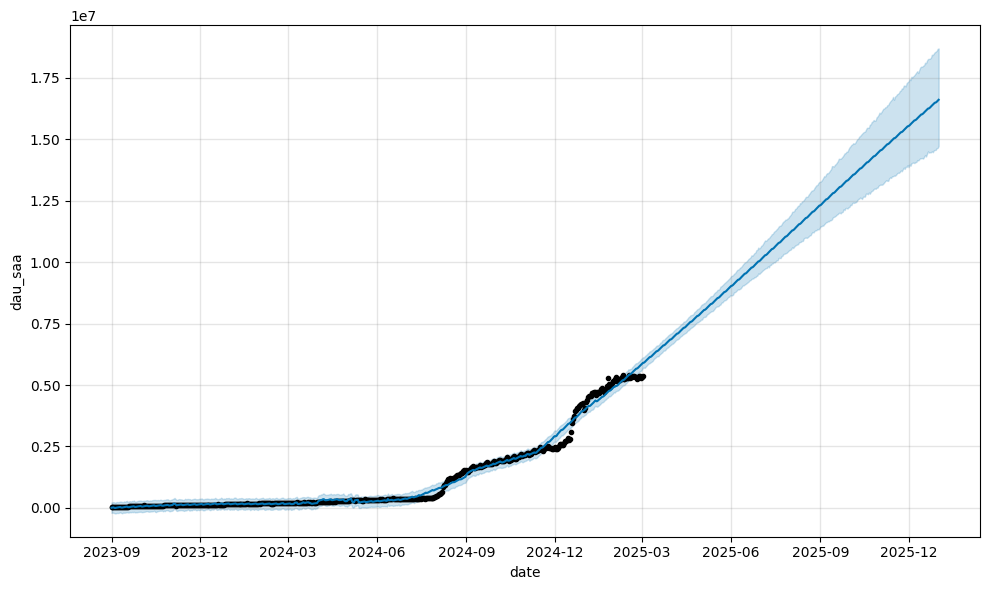

In [101]:
kpi = 'dau_saa'
date_train_start = date_start_dau_saa
date_train_end = date_end_dau_saa

df_scaled_fin.index.name = 'date'

model = Prophet(growth='linear',
            seasonality_mode='additive', 
            weekly_seasonality=True,
            holidays=holidays,
            yearly_seasonality=1, # 2 гармоники 
            seasonality_prior_scale=30)

data = df_scaled_fin.loc[date_train_start:date_train_end,].reset_index().rename(columns = {kpi: 'y', 'date': 'ds'})
data.fillna(0,inplace=True)
model.add_regressor('media_360_shows_others_flights_3_4_5_ots')
model.fit(data)

date_diff = (pd.to_datetime('2026-01-01') - date_train_end).days

future = model.make_future_dataframe(periods=date_diff)
future = pd.concat([future,data.drop(columns=['ds','y'])],axis=1)
future.fillna(0,inplace=True)
# future['cap'] = trend(horizont)

forecast = model.predict(future)

# Визуализация результатов
fig = model.plot(forecast,ylabel=kpi,xlabel='date')
forecast.index = forecast.ds

## DAU SAA Other specification

In [102]:
# df_scaled_fin['multi_dau_loss_youtube_media'] = df_scaled_fin.dau_from_installs_multi_loss_youtube*df_scaled_fin.media_360_shows_total_ots_flight_5
df_scaled_fin['multi_loss_dau_youtube_media'] = df_scaled_fin.loss_dau_youtube_mobile_app_prophet_lci*df_scaled_fin.media_360_shows_total_ots_flight_5

df_scaled_fin['multi_rutube_loss_media'] = df_scaled_fin.rutube_loss_dau_mobile_app*df_scaled_fin.media_360_shows_total_ots_flight_5

df_scaled_fin['multi_loss_dau_rutube_media'] = np.where(df_scaled_fin.rutube_loss_dau_mobile_app==0,0, df_scaled_fin.rutube_loss_dau_mobile_app* df_scaled_fin.media_360_shows_total_ots_flight_5)
df_scaled_fin['multi_loss_installs_rutube_media'] = np.where(df_scaled_fin.rutube_loss_installs==0,df_scaled_fin.rutube_loss_installs, df_scaled_fin.rutube_loss_dau_mobile_app* df_scaled_fin.media_360_shows_total_ots_flight_5)

In [103]:
factors = [
            # 'dummy_new_base_flight1',
            # 'dummy_new_base_flight2',
            # 'dummy_new_base_flight3',
            # 'dummy_new_base_flight4',
            'sba_prophet_mean_wo_media',
            # 'ba_spontaneous_roll_kpi_percent_14_44',
            # 'const',
            'loss_dau_youtube_mobile_app_prophet_lci',
            # 'dau_from_installs_multi_loss_youtube',
            # ----------------------------------
            # 'paid_installs_multi_loss_youtube',
            # 'paid_dau_multi_loss_youtube',
            # 'organic_dau_multi_loss_youtube',
            # 'paid_org_dau_multi_loss_youtube',
            # 'growth_dau_multi_loss_youtube',
            # 'organic_growth_installs_multi_loss_youtube',
            # 'dau_from_installs_multi_loss_youtube',
            # 'installs_total_multi_loss_youtube',
            # 'loss_youtube_prophet_lci',
            # 'rutube_loss_dau_mobile_app',
            # 'multi_loss_rutube_media',
            'lin_rise_loss_rutube_from_android',
            # 'dummy_october',
            # 'multi_media_loss_dau_youtube',
            # 'rutube_loss_dau_mobile_app',
            # 'project_pr_ots',
            # 'project_smm_ots',
            # ----------------------------------
            'competitors_tv_total_ots',
            
            'media_360_shows_other_total_flight_5_ots',
            # 'media_shows_total_ots_flight_5',

            'seasonality_yearly',
            # 'seasonality_weekly',
            # 'seasonality_weekly_since_sept',
            # 'dau_youtube_prophet_uci',
            # 'sba_wo_media',
            # 'dummy_shock',
            # 'log_rise',
            # 'project_aso_app_store',
            # 'mqp_bloggers_tvt_30s_hours',
            # 'const',
            # 'media_360_total_flight_1_2_ots',
           # 'media_360_shows_ots_3_4_flight',
           # 'media_other_total_ots',
            # 'media_360_total_flights_3_4_5_ots',
            # 'media_360_shows_others_flights_3_4_5_ots',
            # 'dau_organic_forecast',
            # 'dau_growth_forecast',
            # 'dau_from_organic_growth_installs',
            # 'dau_paid_forecast',
            # 'mi_vk_fest_ots',
            # 'mi_vkontakte_ots',
            'dau_from_installs',
            # 'project_aso_app_store',
            # 'digital_perf_spends',
            # 'installs_growth_prophet_uci',
            # 'installs_organic_prophet_mean',
            # 'installs_paid_forecast',
          #  'installs_total_predict',
            # 'installs_total_predict_adstock',
            # 'ln_installs_total_predict_adstock'
          ]
kpi = 'dau_saa'
date_train_start = pd.to_datetime('2024-01-01')  #date_start_dau_saa
date_train_end = pd.to_datetime('2024-10-25')#date_end_dau_saa
y_train = df_scaled_fin.loc[date_train_start:date_train_end,kpi].fillna(0)
X_train = df_scaled_fin.loc[date_train_start:date_train_end,factors].fillna(0)

date_forecast = date_train_end + timedelta(days=1)
y_future = df_scaled_fin.loc[date_forecast:,kpi]
X_future = df_scaled_fin.loc[date_forecast:,factors]

model = sm.OLS(y_train, X_train, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(model.summary())

# Predict
y_pred_future = model.predict(X_future)

y_pred_train = model.fittedvalues
print('SMAPE on train: ', round(SMAPE(y_train, y_pred_train), 2), '%')

                                 OLS Regression Results                                
Dep. Variable:                dau_saa   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              1043.
Date:                Fri, 07 Mar 2025   Prob (F-statistic):                   6.02e-194
Time:                        13:49:02   Log-Likelihood:                         -3651.5
No. Observations:                 299   AIC:                                      7317.
Df Residuals:                     292   BIC:                                      7343.
Df Model:                           7                                                  
Covariance Type:                  HAC                                                  
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------

In [104]:
plot_decomposition(pd.concat([y_train,X_train],axis=1).fillna(0),model,kpi_name=kpi)

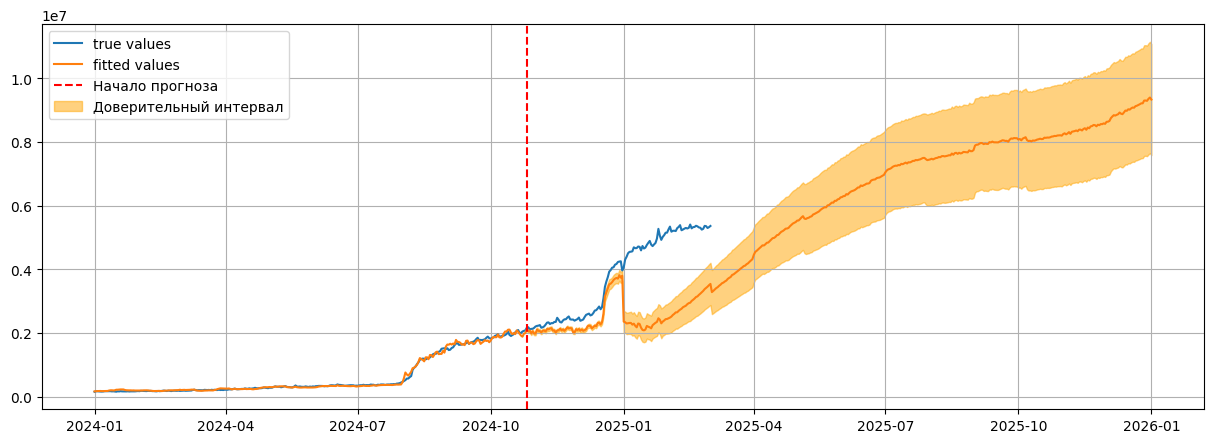

In [105]:
# Рассчитываем прогноз
forecast = model.get_prediction(X_future)

# Точечный рогноз
forecast_values = forecast.predicted_mean
# Интервальный прогноз (доверительный интервал)
forecast_intervals = forecast.conf_int()

plt.figure(figsize=(15, 5))
true_values = pd.concat([y_train,y_future[~y_future.eq(0)]],axis=0)
pred_values = pd.concat([y_pred_train,y_pred_future],axis=0)
plt.plot(true_values,label='true values')
plt.plot(pred_values,label='fitted values')
plt.axvline(x=np.datetime64(date_forecast), color='red', linestyle='--', label='Начало прогноза')
plt.fill_between(y_future.index, forecast_intervals[:, 0], forecast_intervals[:, 1], color='orange', alpha=0.5, label='Доверительный интервал')
plt.legend()
plt.grid(True)
plt.show()


### Media Impact

In [ ]:
kpi = 'dau_saa'
date_flight_start= '2024-09-02'
date_flight_end = '2024-10-06'

df_flowchart = pd.DataFrame({'date_start':[pd.to_datetime(date_flight_start)], 
                                             'date_end':[pd.to_datetime(date_flight_end)], 
                                             'budget':[0.]},
                             index=['tv_360_impact', 
                                    'ooh_360_impact',
                                    'digital_media_360_impact',
                                    'bloggers_360_impact',
                                    'tv_shows_impact',
                                    'digital_media_shows_impact',
                                    'bloggers_shows_impact',
                                    #------------------------------
                                    'media_360_shows_other_total_flight_5_ots',
                                    'loss_dau_youtube_mobile_app_prophet_lci', 
                                    'sba_prophet_mean_wo_media',
                                    'rutube_loss_installs',
                                    # 'project_smm_ots',
                                    'dau_organic_forecast',
                                    'dau_growth_forecast',
                                    'dau_paid_forecast',
                                    'competitors_tv_total_ots',
                                    'seasonality_yearly',
                                    # 'seasonality_weekly',
                                    ])
upd_params = pd.Series({
                        'tv_360_impact':model.params.get('media_360_shows_other_total_flight_5_ots'),
                        'ooh_360_impact':model.params.get('media_360_shows_other_total_flight_5_ots'),
                        'digital_media_360_impact':model.params.get('media_360_shows_other_total_flight_5_ots'),
                        'bloggers_360_impact':model.params.get('media_360_shows_other_total_flight_5_ots'),
                        #-------------------------------------------------------------------------------
                        'tv_shows_impact':model.params.get('media_360_shows_other_total_flight_5_ots'),
                        'digital_media_shows_impact':model.params.get('media_360_shows_other_total_flight_5_ots'),
                        'bloggers_shows_impact':model.params.get('media_360_shows_other_total_flight_5_ots'),
                        #-------------------------------------------------------------------------------
                        'media_360_shows_other_total_flight_5_ots':model.params.get('media_360_shows_other_total_flight_5_ots'),
                        #-------------------------------------------------------------------------------
                        'sba_prophet_mean_wo_media':model.params.get('sba_prophet_mean_wo_media'),
                        'rutube_loss_installs':model.params.get('rutube_loss_installs'),
                        # 'project_smm_ots':model.params.get('project_smm_ots'),
                        #-------------------------------------------------------------------------------
                        'loss_dau_youtube_mobile_app_prophet_lci':model.params.get('loss_dau_youtube_mobile_app_prophet_lci'),
                        #-------------------------------------------------------------------------------
                        'dau_organic_forecast':model.params.get('dau_from_installs'),
                        'dau_growth_forecast':model.params.get('dau_from_installs'),
                        'dau_paid_forecast':model.params.get('dau_from_installs'),
                        'competitors_tv_total_ots':model.params.get('competitors_tv_total_ots'),
                        'seasonality_yearly':model.params.get('seasonality_yearly'),
                        # 'seasonality_weekly':model.params.get('seasonality_weekly'),
                       })

In [ ]:
tv_spends = df['tv_nat_spends'].loc[date_flight_start:date_flight_end].sum() 
tv_shows_spends = df['tv_nat_shows_spends'].loc[date_flight_start:date_flight_end].sum() 
ooh_spends = df[['ooh_spends', 'media_facades_spends',
                     'metro_mcc_spends','universities_spends',
                     'trains_spends','cinemas_spends','fitness_spends',
                     'airports_spends','molls_spends']].loc[date_flight_start:date_flight_end].sum(axis=1).sum()
digital_media_spends = df.digital_media_total_spends.loc[date_flight_start:date_flight_end].sum()
# -----------
digital_media_shows_spends = df.digital_media_shows_spends.loc[date_flight_start:date_flight_end].sum()
bloggers_shows_spends = df.bloggers_shows_spends.loc[date_flight_start:date_flight_end].sum()
# -----------
bloggers_spends = df['bloggers_spends'].loc[date_flight_start:date_flight_end].sum()
project_digital_spends = df['project_digital_spends'].loc[date_flight_start:date_flight_end].sum()
df_flowchart['budget'] = [tv_spends, ooh_spends, digital_media_spends,bloggers_spends,                         
                         tv_shows_spends, digital_media_shows_spends, bloggers_shows_spends
                         ] + 9*[0]

In [ ]:
media_impact_mean = calculate_media_impact(df_scaled_fin,
             df_flow_init=df_flowchart,
             media_factors=['tv_360_impact', 
                                    'ooh_360_impact',
                                    'digital_media_360_impact',
                                    'bloggers_360_impact',
                                    'tv_shows_impact',
                                    'digital_media_shows_impact',
                                    'bloggers_shows_impact'],
             other_factors=[        
                                    'media_360_shows_other_total_flight_5_ots',
                                    'loss_dau_youtube_mobile_app_prophet_lci', 
                                    'sba_prophet_mean_wo_media',
                                    'rutube_loss_installs',
                                    # 'project_smm_ots',
                                    'dau_organic_forecast',
                                    'dau_growth_forecast',
                                    'dau_paid_forecast',
                                    'competitors_tv_total_ots',
                                    'seasonality_yearly',
                                    ],
             target=kpi,
             model=model,
             model_params=upd_params,
             avg_over_period=True) # среднее
media_impact_mean

Scenario without advertising campaign: 1572291.72242


date_start   date_end        budget  \
tv_360_impact                            2024-09-02 2024-10-06 198763188.790   
ooh_360_impact                           2024-09-02 2024-10-06 178906221.902   
digital_media_360_impact                 2024-09-02 2024-10-06  72269418.000   
bloggers_360_impact                      2024-09-02 2024-10-06  21115812.000   
tv_shows_impact                          2024-09-02 2024-10-06  73364913.450   
digital_media_shows_impact               2024-09-02 2024-10-06  43555089.000   
bloggers_shows_impact                    2024-09-02 2024-10-06  16648489.000   
media_360_shows_other_total_flight_5_ots 2024-09-02 2024-10-06         0.000   
loss_dau_youtube_mobile_app_prophet_lci  2024-09-02 2024-10-06         0.000   
sba_prophet_mean_wo_media                2024-09-02 2024-10-06         0.000   
rutube_loss_installs                     2024-09-02 2024-10-06         0.000   
dau_organic_forecast                     2024-09-02 2024-10-06         0.000   
dau_growth_forecast                      2024-09-02 2024-10-06         0.000   
dau_paid_forecast                        2024-09-02 2024-10-06         0.000   
competitors_tv_total_ots                 2024-09-02 2024-10-06         0.000   
seasonality_yearly                       2024-09-02 2024-10-06         0.000   
media_total                              2024-09-02 2024-10-06 604623132.142   

                                          target_fact  impact_weighted  \
tv_360_impact                             1734364.429        52819.831   
ooh_360_impact                            1734364.429        37132.466   
digital_media_360_impact                  1734364.429        28629.673   
bloggers_360_impact                       1734364.429         5776.011   
tv_shows_impact                           1734364.429        22228.437   
digital_media_shows_impact                1734364.429        15174.408   
bloggers_shows_impact                     1734364.429          311.880   
media_360_shows_other_total_flight_5_ots  1734364.429       171540.049   
loss_dau_youtube_mobile_app_prophet_lci   1734364.429       799167.047   
sba_prophet_mean_wo_media                 1734364.429       118770.350   
rutube_loss_installs                      1734364.429              NaN   
dau_organic_forecast                      1734364.429       234550.704   
dau_growth_forecast                       1734364.429        60922.000   
dau_paid_forecast                         1734364.429       355862.489   
competitors_tv_total_ots                  1734364.429       -42339.255   
seasonality_yearly                        1734364.429        20934.409   
media_total                               1734364.429       162072.706   

                                          increment  share      CPA  \
tv_360_impact                                 3.141  3.045  107.515   
ooh_360_impact                                2.188  2.141  137.659   
digital_media_360_impact                      1.678  1.651   72.122   
bloggers_360_impact                           0.334  0.333  104.451   
tv_shows_impact                               1.298  1.282   94.300   
digital_media_shows_impact                    0.883  0.875   82.009   
bloggers_shows_impact                         0.018  0.018 1525.175   
media_360_shows_other_total_flight_5_ots     10.976  9.891    0.000   
loss_dau_youtube_mobile_app_prophet_lci      85.454 46.078    0.000   
sba_prophet_mean_wo_media                     7.351  6.848    0.000   
rutube_loss_installs                            NaN    NaN      NaN   
dau_organic_forecast                         15.639 13.524    0.000   
dau_growth_forecast                           3.641  3.513    0.000   
dau_paid_forecast                            25.815 20.518    0.000   
competitors_tv_total_ots                     -2.383 -2.441   -0.000   
seasonality_yearly                            1.222  1.207    0.000   
media_total                                  10.308  9.345  

## Multiplicative models DAU SAA

In [ ]:
df_scaled_fin['ln_dau_saa'] = np.log1p(df_scaled_fin.dau_saa)
df_scaled_fin['ln_installs_total_predict'] = np.log1p(df_scaled_fin.installs_total_predict)
df_scaled_fin['ln_dau_from_installs_multi_loss_youtube'] = np.log1p(df_scaled_fin.dau_from_installs_multi_loss_youtube)
df_scaled_fin['ln_media_other_total_ots']  =  np.log1p(df_scaled_fin.media_other_total_ots)
df_scaled_fin['ln_loss_youtube_prophet_lci'] = np.log1p(df_scaled_fin.loss_dau_youtube_mobile_app_prophet_lci)
kpi = 'ln_dau_saa'

In [ ]:
factors = [
            # 'dummy_new_base_flight1',
            # 'dummy_new_base_flight2',
            # 'dummy_new_base_flight3',
            # 'dummy_new_base_flight4',
            # 'sba_prophet_mean',
            'loss_dau_youtube_mobile_app_prophet_lci',
            # 'ln_loss_youtube_prophet_lci',
            # 'ln_dau_from_installs_multi_loss_youtube',
            # ----------------------------------
            # 'paid_installs_multi_loss_youtube',
            # 'installs_total_multi_loss_youtube',
            # 'dau_from_installs_multi_loss_youtube',
            # 'dau_from_installs_multi_loss_youtube_media',
            # 'ln_dau_from_installs_multi_loss_youtube',
            # ----------------------------------
            # 'seasonality_weekly_since_sept',
            # 'competitors_tv_total_ots',
            # 'dau/mau',
            # 'media_other_total_ots',
            # 'media_360_shows_total_flights_3_4_ots',
            # 'media_shows_total_ots',
            # 'media_360_total_flights_3_4_ots',
            'ln_media_other_total_ots',
            # 'media_360_total_flight_5_ots',
            # 'ln_media_360_shows_total_flights_3_4_ots',
            'media_360_shows_other_total_flight_5_ots',
            # 'ln_media_360_offline_flight_5',
            # 'ln_media_360_online_flight_5',
            # 'ln_tv_nat_ots_ta_14_54_flight_5',
            # 'ln_media_outdoor_total_ots_geo_flight_5',
            # 'ln_digital_media_total_ots_total_flight_5',
            # 'ln_bloggers_ots_total_flight_5',
            # 'media_shows_total_ots'
            # 'seasonality_yearly',
            # 'seasonality_weekly',
            # 'dau_youtube_prophet_uci',
            # 'sba_wo_media',
            # 'dummy_shock',
            # 'log_rise',
            # 'project_aso_app_store',
            # 'seasonality_weekly',
            # 'mqp_bloggers_tvt_30s_hours',
            'const',
            # 'media_360_total_flight_1_2_ots',
           # 'media_360_shows_ots_3_4_flight',
           # 'media_other_total_ots',
            # 'media_360_total_flights_3_4_5_ots',
            # 'media_360_shows_others_flights_3_4_5_ots',
            # 'dau_organic_forecast',
            # 'dau_growth_forecast',
            # 'dau_paid_forecast',
            # 'dau_from_installs',
            # 'project_aso_app_store',
            # 'digital_perf_spends',
            # 'installs_growth_prophet_uci',
            # 'installs_organic_prophet_mean',
            # 'installs_paid_forecast',
          #  'installs_total_predict'
          'ln_installs_total_predict',
            # 'installs_total_predict_adstock',
            # 'ln_installs_total_predict_adstock'
          ]
date_train_start = date_start_dau_saa
date_train_end = date_end_dau_saa
y_train = df_scaled_fin.loc[date_train_start:date_train_end,kpi]
X_train = df_scaled_fin.loc[date_train_start:date_train_end,factors]


date_forecast = date_train_end + timedelta(days=1)
y_future = df_scaled_fin.loc[date_forecast:,kpi]
X_future = df_scaled_fin.loc[date_forecast:,factors]

model = sm.OLS(y_train, X_train, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(model.summary())

# Predict
y_pred_future = np.expm1(model.predict(X_future))

y_pred_train = np.expm1(model.fittedvalues)
print('SMAPE on train: ', round(SMAPE(np.expm1(y_train), y_pred_train), 2), '%')

                            OLS Regression Results                            
Dep. Variable:             ln_dau_saa   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     713.6
Date:                Thu, 28 Nov 2024   Prob (F-statistic):          9.19e-193
Time:                        13:48:15   Log-Likelihood:                -116.65
No. Observations:                 453   AIC:                             243.3
Df Residuals:                     448   BIC:                             263.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [ ]:
plot_decomposition(pd.concat([y_train,X_train],axis=1).fillna(0),model,kpi_name=kpi)

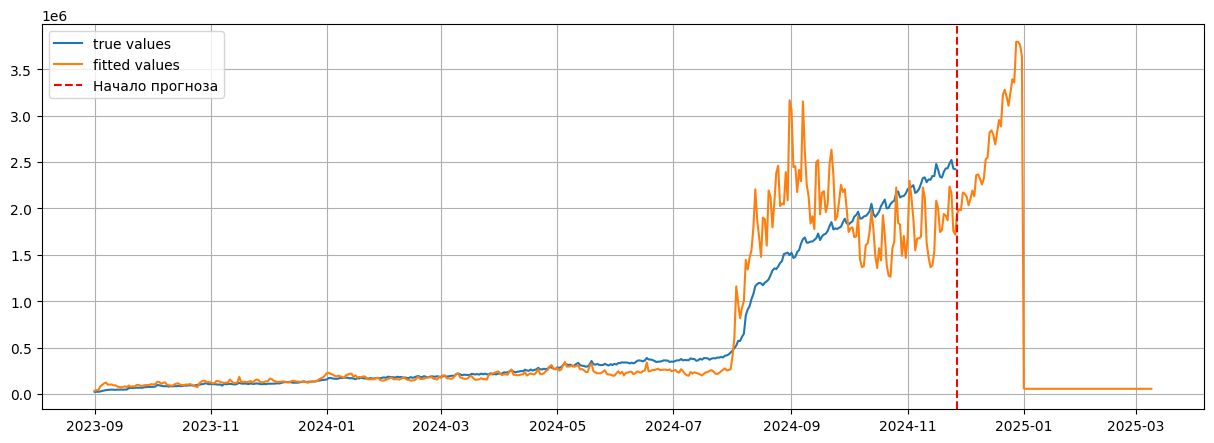

In [ ]:
plt.figure(figsize=(15, 5))
true_values = pd.concat([np.expm1(y_train),np.expm1(y_future)[~y_future.eq(0)]],axis=0)
pred_values = pd.concat([y_pred_train,y_pred_future],axis=0)
plt.plot(true_values,label='true values')
plt.plot(pred_values,label='fitted values')
plt.axvline(x=np.datetime64(date_forecast), color='red', linestyle='--', label='Начало прогноза')
plt.legend()
plt.grid(True)
plt.show()